# Exp 11. 주식 예측에 도전해보자

# 🗼 목차
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 파라미터 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기  
1) 삼성전자  
2) Coca-Cola  
3) Pepsi  
4) Disney  
5) Netfilx  

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller   # ADF test 수행
from statsmodels.tsa.seasonal import seasonal_decompose  # 시계열 분해
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF, PACF 그리기
from statsmodels.tsa.arima.model import ARIMA  # ARIMA 모델
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


import warnings
warnings.filterwarnings('ignore')

# [[삼성전자]](https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS)
* 칼럼 종류: Date(날짜), 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
* 여기서는 종가(Close)만 사용한다.

# Step 1. 시계열 데이터 준비

* 삼성전자 주식 데이터 파일을 DataFrame으로 불러왔다.
* 날짜(Date)를 기준으로 칼럼들의 데이터가 저장되어 있다.
* 이것은 아직 시계열의 데이터 구조가 아니다.

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
samsung = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
samsung.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


* 시계열 데이터로 불러왔다.
* DataFrame인 `samsung`와 Series인 `samsung['Close']`는 index 구조가 동일하므로 Numpy, Pandas, Matplotlib 등 많은 라이브러리들이 호환해서 지원해준다.
* 간혹 그렇지 않은 경우도 발생하니 여기서는 명확하게 Seires 객체를 가지고 진행하였다.

In [3]:
ts_ss = samsung['Close']
ts_ss.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

* 삼성전자의 데이터를 차트로 그려보았다.

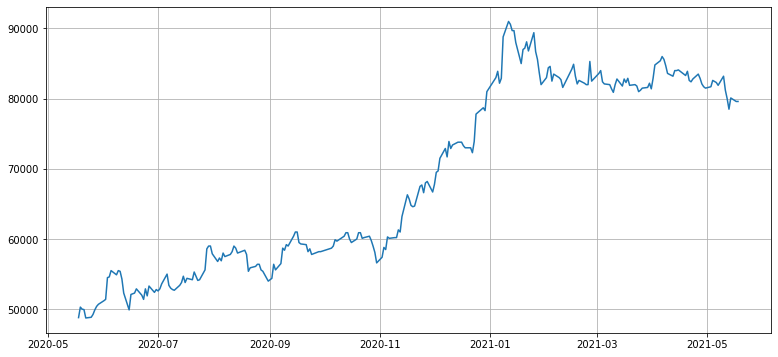

In [4]:
rcParams['figure.figsize'] = 13, 6 

plt.grid(True)
plt.plot(ts_ss)

---

# Step 2. 각종 전처리 수행

## 2.1 결측치 처리
* 결측치는 없는 것으로 확인되었다.

In [5]:
ts_ss = ts_ss.interpolate(method='time')
ts_ss[ts_ss.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

## 2.2 로그 변환
* 로그 변환을 해주었으며, 변환 후 그래프도 확인해보았다.
* 원 데이터 그래프와 로그 변환된 그래프의 큰 차이가 없어서 수치로 비교해봐야 한다.

In [6]:
ts_ss_log = np.log(ts_ss)

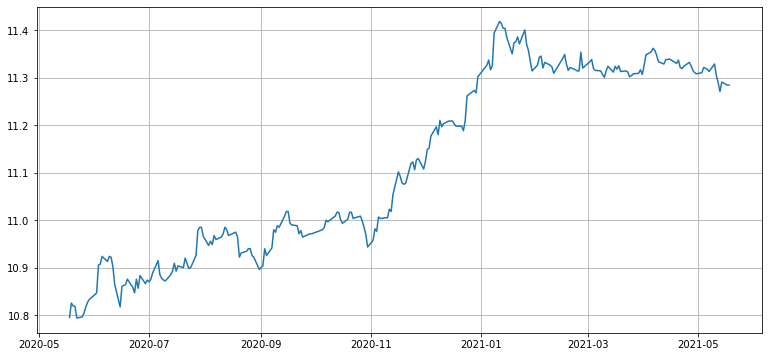

In [7]:
plt.grid(True)
plt.plot(ts_ss_log)

---

# Step 3. 시계열 안정성 분석

## 3.1 정성적 그래프 분석
* 일정시간 내 `구간 통계치(Rolling Statistics)`를 시각화해보는 함수를 구현해보자.
* 현재 타임 스텝부터 window에 주어진 타임스텝 이전 사이 `구간의 평균(이동 평균)`과 `표준편차`를 원본 시계열과 함께 시각화해보자.

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
print('슝=3')

슝=3


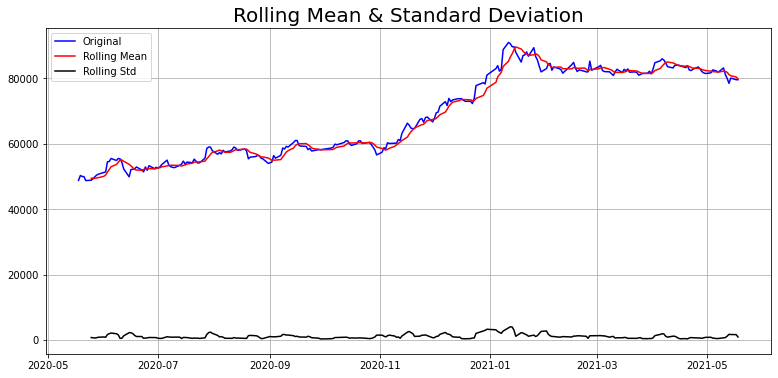

In [9]:
plt.grid(True)
plot_rolling_statistics(ts_ss, window=6)    # time step은 6으로 함.

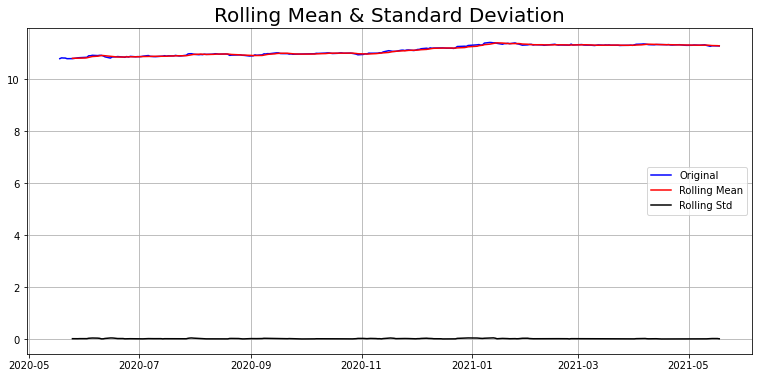

In [10]:
plt.grid(True)
plot_rolling_statistics(ts_ss_log, window=6)

## 3.2 정량적 Augmented Dicky-Fuller Test
* statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 시계열에 대한 `ADF Test`를 수행할 수 있다.

> * 귀무가설 : 이 시계열 데이터가 안정적이지 않다.
> * 대립가설 : 이 시계열 데이터가 안정적이다.

* 로그변환을 한 것의 p-value값이 조금 낮아지긴 하였지만 여전히 0.05 이상이기 때문에 귀무가설을 기각할 수는 없다.
* 아직은 이 시계열 데이터가 안정적이지 않다고 볼 수 있다.

In [11]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [12]:
augmented_dickey_fuller_test(ts_ss)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [13]:
augmented_dickey_fuller_test(ts_ss_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


## 3.3 시계열 분해(Time Series Decomposition)
* statsmodels 라이브러리 안에는 `seasonal_decompose`메서드를 통해 시계열 안에 존재하는 `추세(trend)`, `계절성(seasonality)`를 직접 분리해 낼 수 있는 기능이 있다.
* 이 기능을 활용하면 `moving average 제거(trend 상쇄)`, `differencing(seasonality 상쇄)` 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.

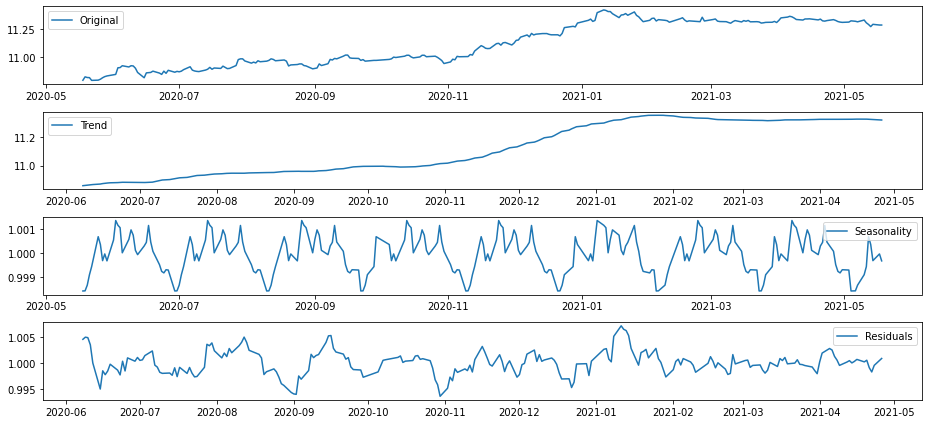

In [14]:
decomposition = seasonal_decompose(ts_ss_log, model='multiplicative', period = 30) 

trend_ss = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal_ss = decomposition.seasonal     # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_ss = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_ss_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_ss, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_ss,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_ss, label='Residuals')   # original 시계열에서 trend와 seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

## 3.4 Residual 안정성 확인
* `Decomposing`을 통해 얻어진 `Residual`은 압도적으로 낮은 `p-value`를 보여준다.
* 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다.

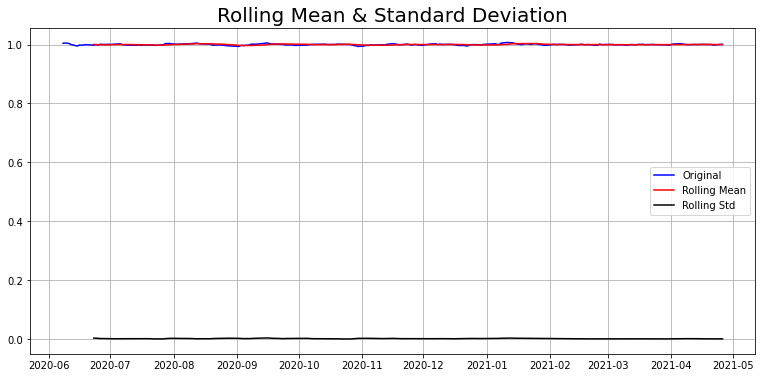

In [15]:
plt.grid(True)
plot_rolling_statistics(residual_ss)

In [16]:
residual_ss.dropna(inplace=True)
augmented_dickey_fuller_test(residual_ss)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


---

# Step 4. 학습, 테스트 데이터셋 생성
* 시계열 데이터에서 학습 데이터와 테스트 데이터를 분리하였다.
* 분리 비율은 학습과 테스트에 9:1로 하였다.
* 시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것이다.

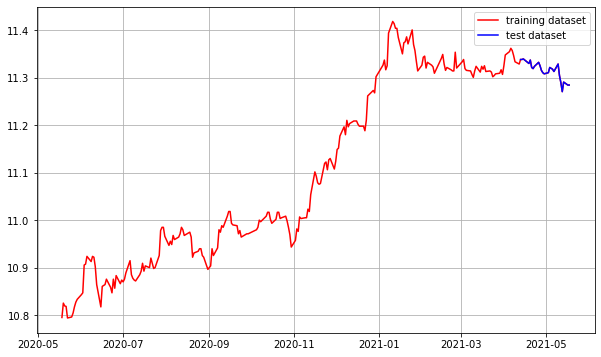

In [17]:
train_data, test_data = ts_ss_log[:int(len(ts_ss_log)*0.9)], ts_ss_log[int(len(ts_ss_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(ts_ss_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

In [18]:
print(ts_ss_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


---

# Step 5. 적정 ARIMA 파라미터 찾기
* p : 자기회귀 모형(AR)의 시차
* d : 차분 누적(I) 횟수
* q : 이동평균 모형(MA)의 시차
* 일반적으로 `p + q < 2`, `p * q = 0` 인 값을 사용한다.  
    → p나 q 둘 중 하나는 0이라는 뜻이다.  
    → 이유는 많은 시계열 데이터가 `AR`이나 `MA` 중 하나의 경향만 가지기 때문이다.

## 5.1 ACF, PACF 그려보기 (→ p,q 결정)

### ACF
* 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
* 주어진 시계열의 현재 값이 과거값과 어떻게 상관되는지 설명함
* ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

### PACF
* 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
* k 이외의 모든 시차를 갖는 관측치의 영향력을 배제한 가운데 특정 두 관측치가 얼마나 관련이 있는지 나타내는 척도

* ACF를 통해 MA모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있다.  
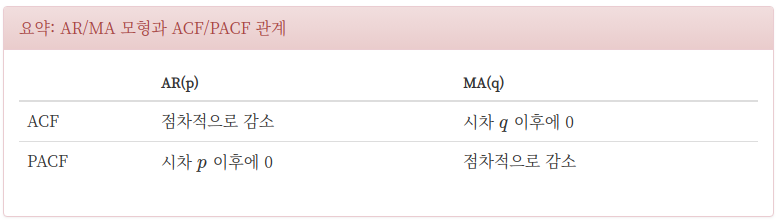

* `PACF`그래프를 볼 때, `p=1`이 적합하다.
    * p가 2 이상인 구간에서는 `PACF`는 거의 0에 가까워지고 있기 때문이다.
    * `PACF`가 0이라는 의미 : 현재 데이터와 p 시점 떨어진 이전 데이터는 상관도가 0, 즉 아무 상관없는 데이터이기에 고려할 필요가 없다.
* `ACF`는 점진적으로 감소하고 있어서 적합한 q값을 정할 수 없다.
    * `MA`를 고려할 필요가 없다면 `q=0`으로 둘 수 있지만 q를 바꿔가면서 확인해보는 것도 좋다.

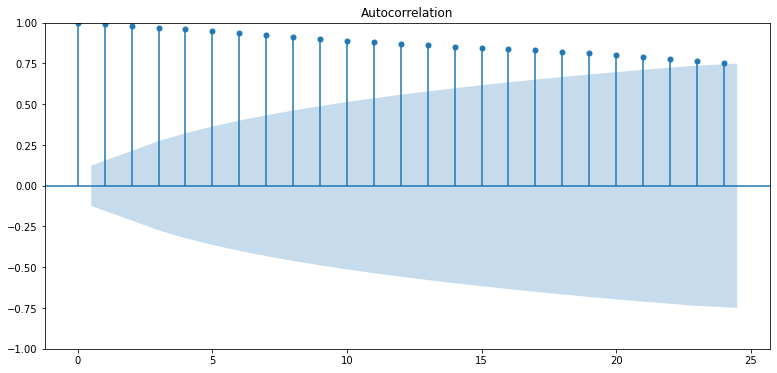

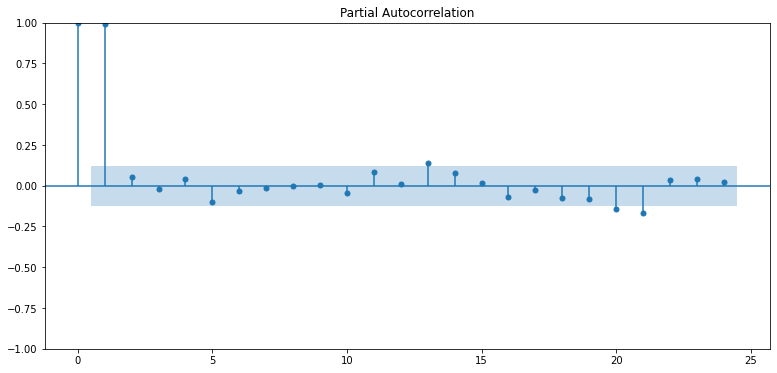

In [19]:
plot_acf(ts_ss_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_ss_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## 5.2 차분 안정성 확인(→ d 결정)
* 1차 차분을 구해보고 시계열이 안정된 상태인지 확인해보았다.
* 1차 차분 후 다시 `ACF`, `PACF`를 그려보았다.
* p와 q 모두 0이다. 둘 중 하나만 0이 되어야 하는 것이 아닌가,,?
* 하지만 정상 시계열의 경우, `ACF`는 빠르게 0으로 떨어진다고 하였으니 정상 시계열인 것 같기도 하다

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


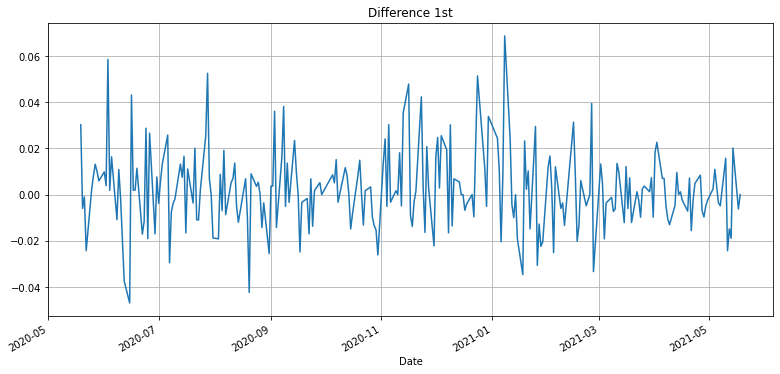

In [20]:
# 1차 차분 구하기
diff_ss_1 = ts_ss_log.diff(periods=1).iloc[1:]
diff_ss_1.plot(title='Difference 1st')
plt.grid(True)

augmented_dickey_fuller_test(diff_ss_1)

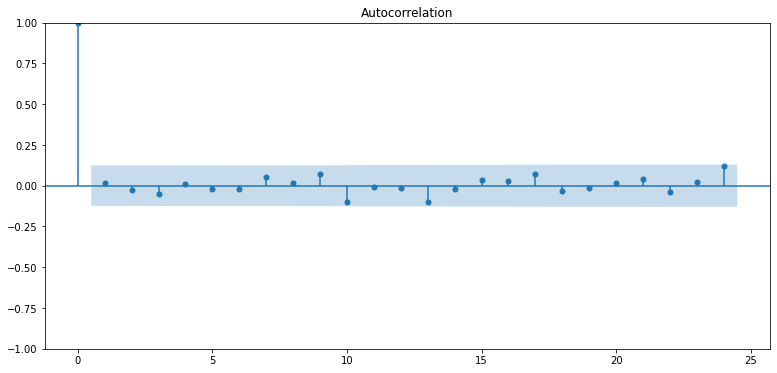

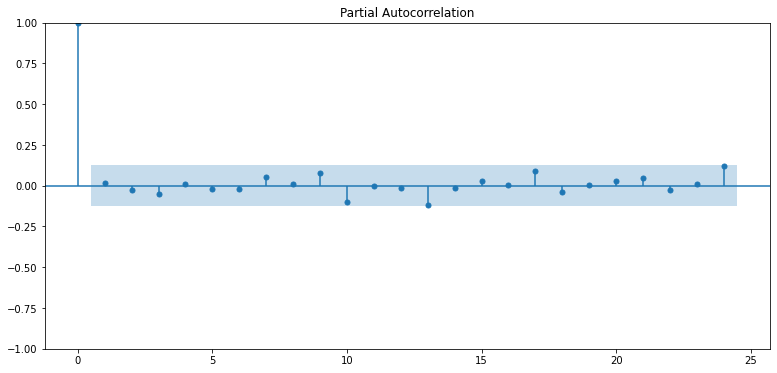

In [21]:
plot_acf(diff_ss_1)   
plot_pacf(diff_ss_1)
plt.show()

---

# Step 6. ARIMA 모델 훈련과 테스트

* 전 STEP에서 ARIMA 모델의 파라미터 값(p, d, q)을 확인하였을 때, 총 2가지를 생각해볼 수 있다.
    * p = 1, d = 0, q = 0 : 차분을 하지 않았을 때
    * p = 0, d = 1, q = 0 : 1차 차분을 하였을 때  
    → 여기서 궁금한 것은, p와 q 모두 0이 되어도 되냐는 것이다. 대부분의 시계열 자료는 하나의 경향을 강하게 띄는데, 이 부분은 이상하다고 생각이 되었다. 하지만 우선 진행해보기로 하였다.

# [p = 1, d = 0, q = 0]
* 1차 차분을 하지 않은 ARIMA 모델이다.
* 예측 값이 실제 값과 유사하게 하강하는 형태를 띈다.
* `MAPE`도 `1.05%`로 낮은 것을 확인할 수있다.

## 6.1 ARIMA 모델 빌드와 훈련

In [22]:
model_1 = ARIMA(train_data, order=(1, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 583.082
Date:                Thu, 17 Feb 2022   AIC                          -1160.164
Time:                        09:12:41   BIC                          -1149.916
Sample:                             0   HQIC                         -1156.028
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.115     96.195      0.000      10.864      11.316
ar.L1          0.9937      0.006    168.571      0.000       0.982       1.005
sigma2         0.0003   2.45e-05     13.135      0.0

## 6.2 모델 테스트 및 플로팅

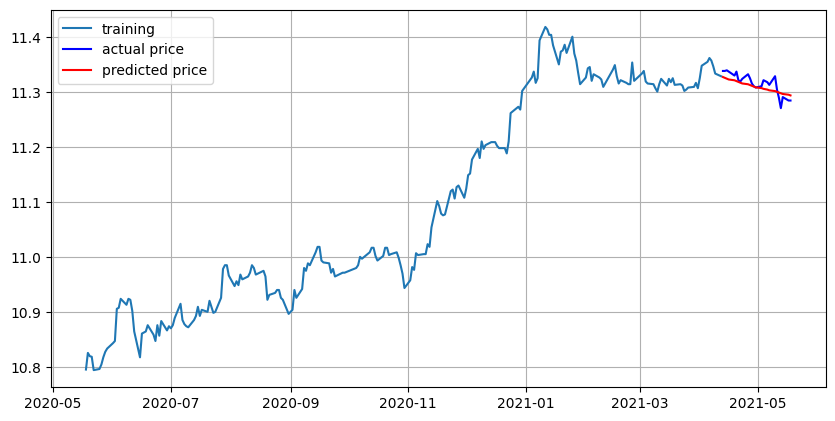

In [23]:
# Forecast : 결과가 fc에 담깁니다. 

fc_1 = fitted_m_1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)

# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

## 6.3 최종 예측 모델 정확도 측정(MAPE)

In [24]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1078734.6873192338
MAE:  866.9125685447763
RMSE:  1038.621532281723
MAPE: 1.05%


# [p = 0, d = 1, q = 0]
* 1차 차분을 한 ARIMA 모델이다.
* 그래프를 보면 예측 값이 그냥 일자이다.
* `MAPE`는 `1.74%`로 1차 차분을 하지 않은 모델에 비해서 높다.

## 6.1 ARIMA 모델 빌드와 훈련

In [25]:
model_2 = ARIMA(train_data, order=(0, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m_2 = model_2.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 17 Feb 2022   AIC                          -1164.726
Time:                        09:12:41   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

## 6.2 모델 테스트 및 플로팅

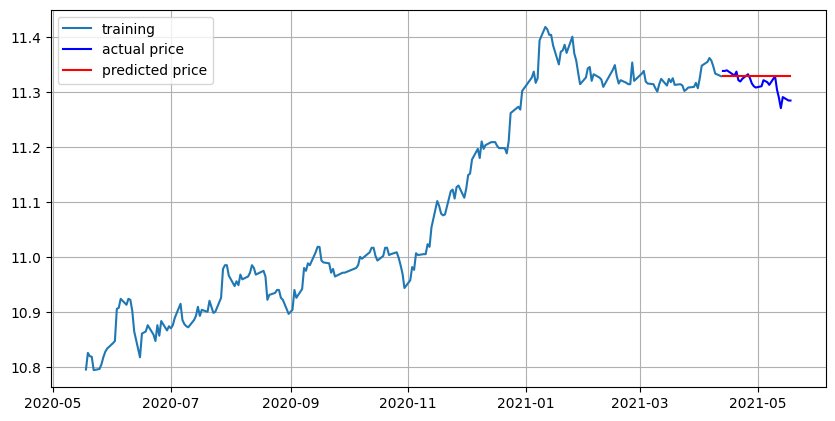

In [26]:
# Forecast : 결과가 fc에 담깁니다. 

fc_2 = fitted_m_2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)

# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

## 6.3 최종 예측 모델 정확도 측정(MAPE)

In [27]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


## ▶ 최종 MAPE : 1.05% (p = 1, d = 0, q = 0)

---

# Step 7. 다른 주식 종목 예측해보기

# [[Coca-Cola]](https://finance.yahoo.com/quote/KO?p=KO&.tsrc=fin-srch)

## 1. 시계열 데이터 준비

In [28]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/KO.csv'
cocacola = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
cocacola.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,50.000000,50.490002,49.889999,50.130001,48.597893,12794300
2021-02-18,50.160000,50.849998,50.029999,50.770000,49.218334,12747100
2021-02-19,50.790001,50.830002,49.970001,50.110001,48.578506,15968800
2021-02-22,49.849998,50.880001,49.669998,50.630001,49.082615,14370900
2021-02-23,51.000000,51.509998,50.419998,50.540001,48.995358,16222300


In [29]:
ts_cc = cocacola['Close']
ts_cc.head()

Date
2021-02-17    50.130001
2021-02-18    50.770000
2021-02-19    50.110001
2021-02-22    50.630001
2021-02-23    50.540001
Name: Close, dtype: float64

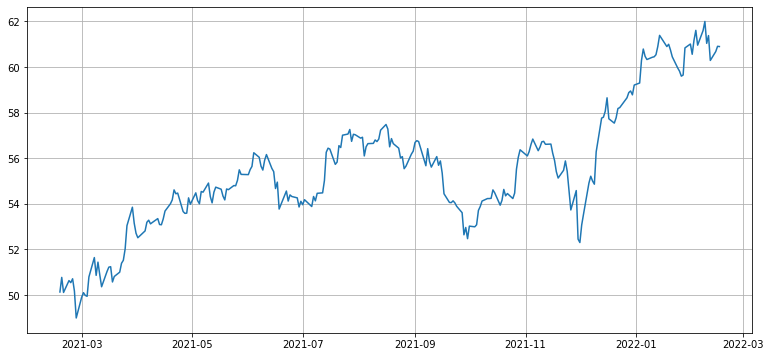

In [30]:
rcParams['figure.figsize'] = 13, 6 

plt.grid(True)
plt.plot(ts_cc)

## 2. 각종 전처리 수행

In [31]:
# 결측치 처리
ts_cc = ts_cc.interpolate(method='time')
ts_cc[ts_cc.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [32]:
# 로그 변환
ts_cc_log = np.log(ts_cc)

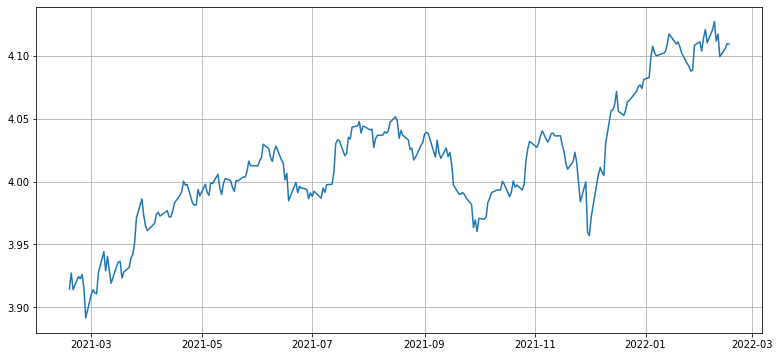

In [33]:
plt.grid(True)
plt.plot(ts_cc_log)

## 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

In [34]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
print('슝=3')

슝=3


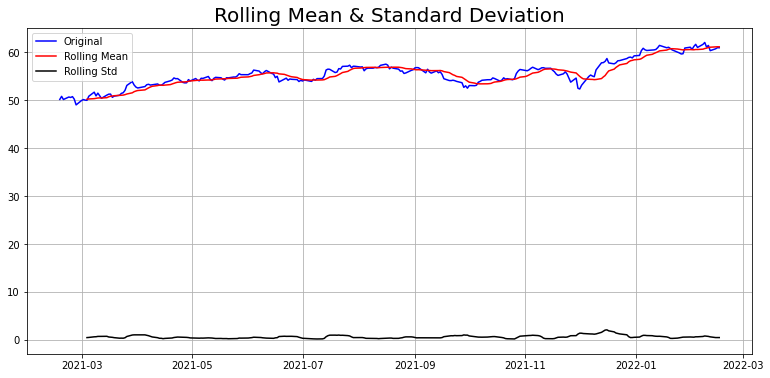

In [35]:
plt.grid(True)
plot_rolling_statistics(ts_cc, window=12)    # time step은 12으로 함.

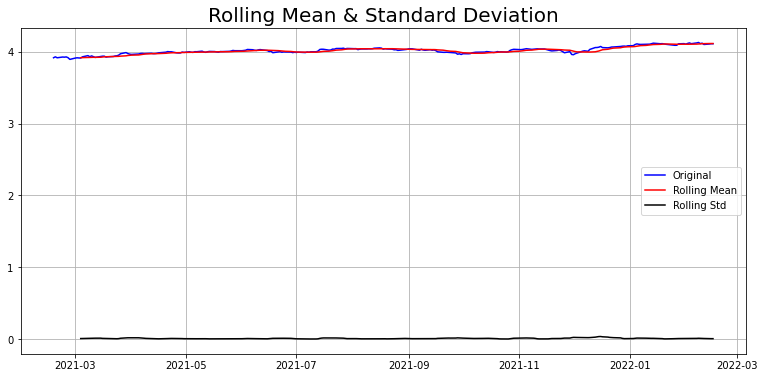

In [36]:
plt.grid(True)
plot_rolling_statistics(ts_cc_log, window=12)

### 3.2 정량적 Augmented Dicky-Fuller Test
* 원 데이터, 로그 변환 데이터 모두 `p-value`값이 0.05 이상이기에 귀무가설을 기각할 수 없다.
* 아직은 이 시계열 데이터가 안정적이지 않다고 볼 수 있다

In [37]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [38]:
augmented_dickey_fuller_test(ts_cc)

Results of Dickey-Fuller Test:
Test Statistic                  -1.375713
p-value                          0.593863
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [39]:
augmented_dickey_fuller_test(ts_cc_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.493487
p-value                          0.536731
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


### 3.3 시계열 분해

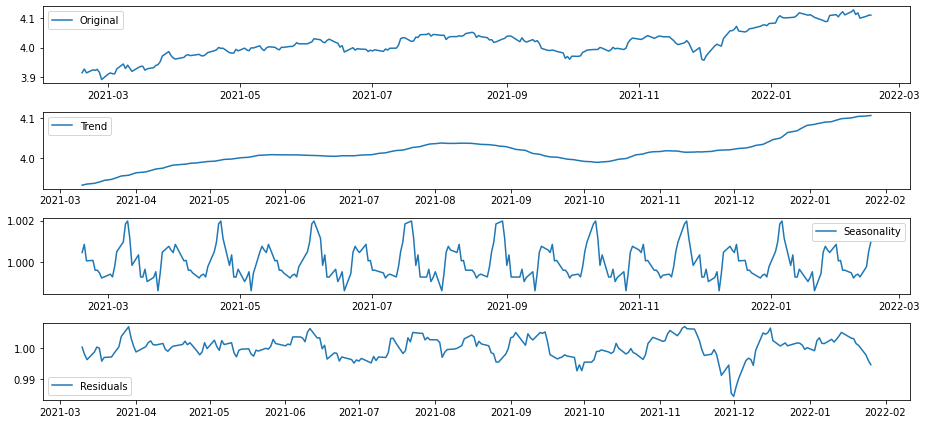

In [40]:
decomposition = seasonal_decompose(ts_cc_log, model='multiplicative', period = 30) 

trend_cc = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal_cc = decomposition.seasonal     # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_cc = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_cc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_cc, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_cc,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_cc, label='Residuals')   # original 시계열에서 trend와 seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인
* `Residual`은 낮은 `p-value`를 보여준다.
* 예측 가능한 수준의 안정적인 시계열이 얻어졌다.

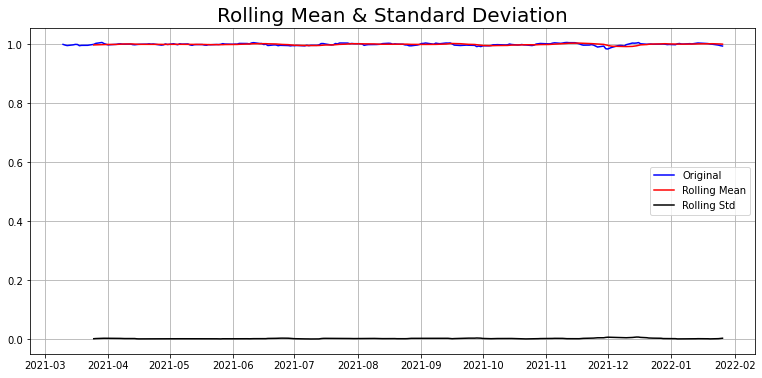

In [41]:
plt.grid(True)
plot_rolling_statistics(residual_cc)

In [42]:
residual_cc.dropna(inplace=True)
augmented_dickey_fuller_test(residual_cc)

Results of Dickey-Fuller Test:
Test Statistic                  -4.662114
p-value                          0.000099
#Lags Used                      11.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

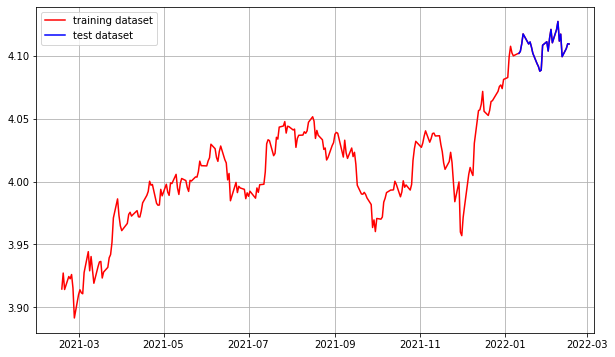

In [43]:
train_data, test_data = ts_cc_log[:int(len(ts_cc_log)*0.9)], ts_cc_log[int(len(ts_cc_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(ts_cc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

In [44]:
print(ts_cc_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2021-02-17    3.914620
2021-02-18    3.927306
Name: Close, dtype: float64
(228,)
(26,)


## 5. 적정 ARIMA 파라미터 찾기

### 5.1 ACF, PACF 그려보기 (→ p,q 결정)
* `PACF` 그래프를 보면 `p = 1`이 적합하다.
* `ACF`는 점진적으로 감소하고 있기에 `q = 0`으로 설정하고자 한다.

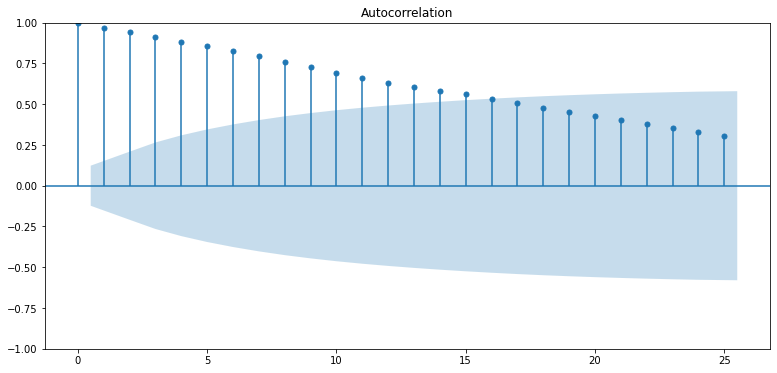

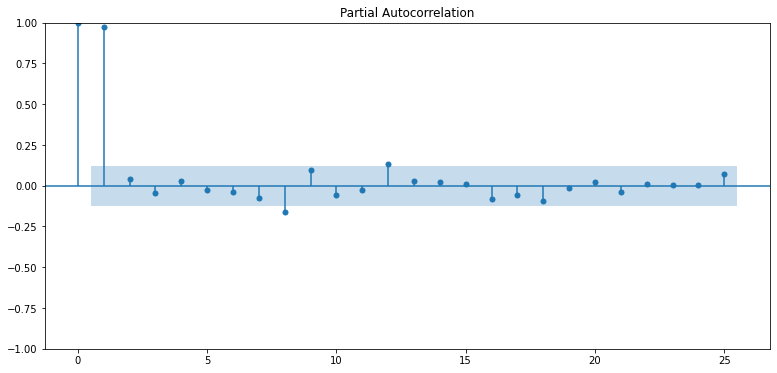

In [45]:
plot_acf(ts_cc_log)  
plot_pacf(ts_cc_log) 
plt.show()

### 5.2 차분 안정성 확인(→ d 결정)
* 위에서 진행한 삼성전자와 동일하게 1차 차분을 하였을 때, ACF, PACF 그래프가 나왔다.
* p와 q가 모두 0이 되는데, 삼성전자와 동일하게 처리해보고자 한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.660787e+01
p-value                        1.741386e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


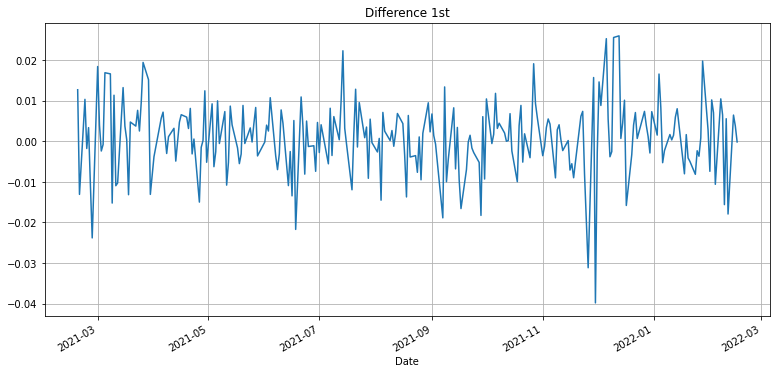

In [46]:
# 1차 차분 구하기
diff_cc_1 = ts_cc_log.diff(periods=1).iloc[1:]
diff_cc_1.plot(title='Difference 1st')
plt.grid(True)

augmented_dickey_fuller_test(diff_cc_1)

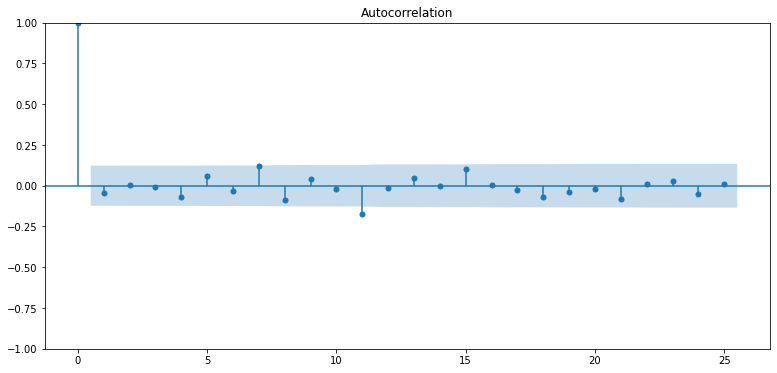

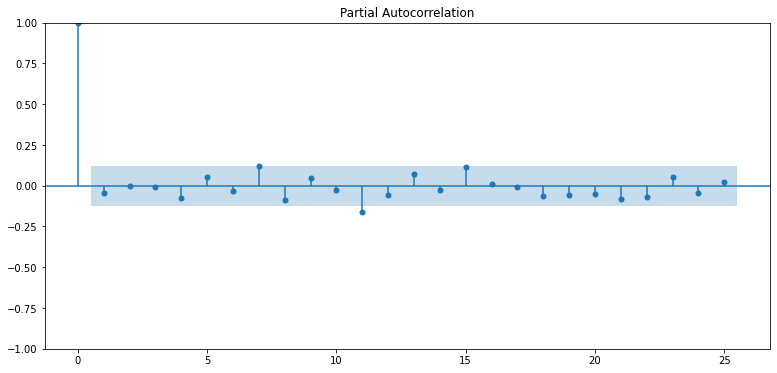

In [47]:
plot_acf(diff_cc_1)   
plot_pacf(diff_cc_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.636386e+00
p-value                        1.947392e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


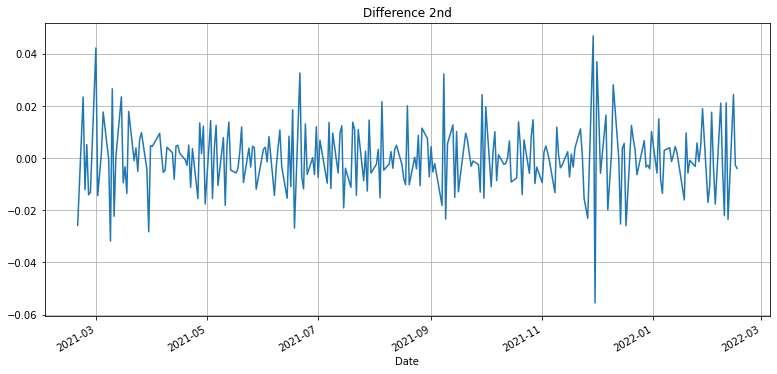

In [48]:
# 2차 차분 구하기
diff_cc_2 = diff_cc_1.diff(periods=1).iloc[1:]
diff_cc_2.plot(title='Difference 2nd')
plt.grid(True)

augmented_dickey_fuller_test(diff_cc_2)

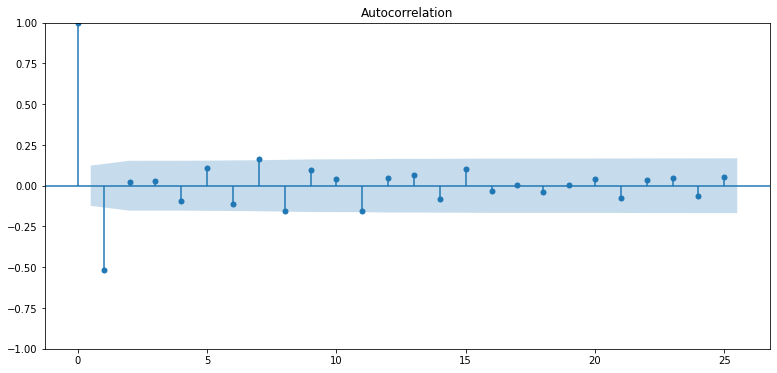

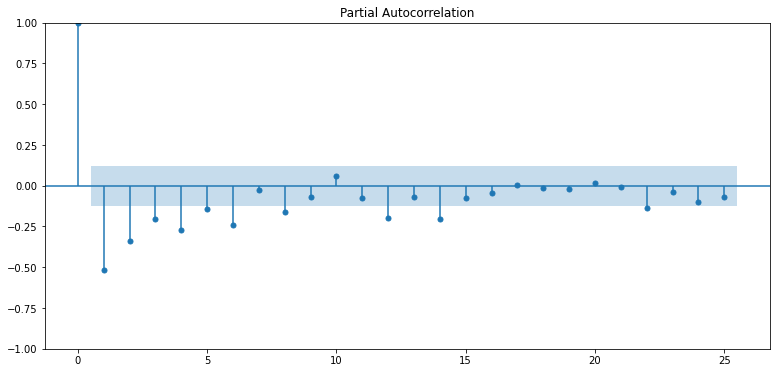

In [49]:
plot_acf(diff_cc_2)   
plot_pacf(diff_cc_2)
plt.show()

## 6. ARIMA 모델 훈련과 테스트

## [p = 1, d = 0, q = 0]
* 실제 그래프는 하락+상승하고 있는데 예측 그래프는 하락하고 있다.
* `MAPE`는 `3.03%`이다.
* 예측을 잘하지 못하였다.

### 6.1 ARIMA 모델 빌드와 훈련

In [50]:
model_1 = ARIMA(train_data, order=(1, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 747.539
Date:                Thu, 17 Feb 2022   AIC                          -1489.078
Time:                        09:12:45   BIC                          -1478.790
Sample:                             0   HQIC                         -1484.927
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0035      0.022    185.384      0.000       3.961       4.046
ar.L1          0.9772      0.013     74.935      0.000       0.952       1.003
sigma2      8.196e-05   5.52e-06     14.840      0.0

### 6.2 모델 테스트 및 플로팅

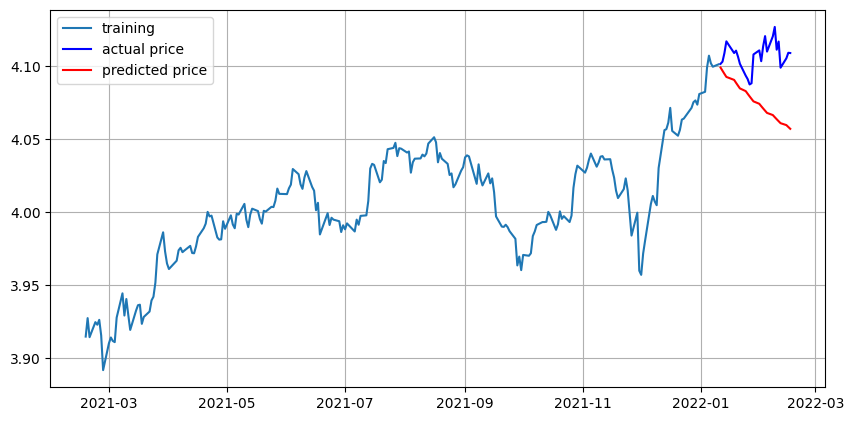

In [51]:
# Forecast : 결과가 fc에 담깁니다. 

fc_1 = fitted_m_1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)

# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [52]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.554341449343941
MAE:  1.8515851207835006
RMSE:  2.13409030955673
MAPE: 3.03%


## [p = 0, d = 1, q = 0]

### 6.1 ARIMA 모델 빌드와 훈련
* 1차 차분을 한 모델로, 그래프는 일직선임을 확인할 수 있다.
* 1차 차분을 하지 않은 모델에 비해서는 예측을 잘하였다.
* `MAPE`는 `0.94%`로 1차 차분하지 않은 모델에 비해 많이 낮다는 것을 확인할 수 있다.

In [53]:
model_2 = ARIMA(train_data, order=(0, 1, 0)) 
fitted_m_2 = model_2.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 746.306
Date:                Thu, 17 Feb 2022   AIC                          -1490.613
Time:                        09:12:45   BIC                          -1487.188
Sample:                             0   HQIC                         -1489.231
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.155e-05    5.4e-06     15.105      0.000     7.1e-05    9.21e-05
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                55.59
Prob(Q):                              0.66   Pr

### 6.2 모델 테스트 및 플로팅

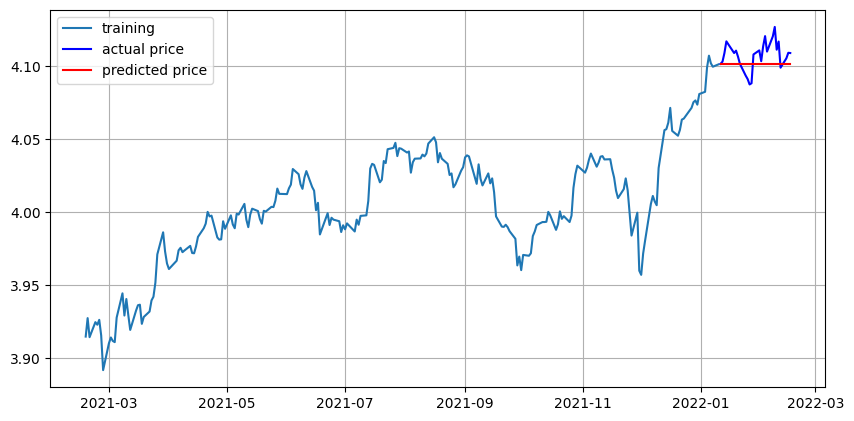

In [54]:
# Forecast : 결과가 fc에 담깁니다. 

fc_2 = fitted_m_2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)

# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

### 6.3 최종 예측 모델 정확도 측정(MAPE)

In [55]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.4651116369245697
MAE:  0.5711541153846093
RMSE:  0.6819909361014775
MAPE: 0.94%


## [p = 0, d = 2, q = 1]
* 실제 그래프가 하락+상승하고 있지만 전반적으로 상승하는 그래프이다.
* 2차 차분한 예측 그래프도 상승을 하고 있으며 `MAPE`도 `0.88%`로 낮아 가장 예측을 잘하였다.

In [56]:
model_3 = ARIMA(train_data, order=(0, 2, 1)) 
fitted_m_3 = model_3.fit() 

print(fitted_m_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 740.749
Date:                Thu, 17 Feb 2022   AIC                          -1477.499
Time:                        09:12:46   BIC                          -1470.658
Sample:                             0   HQIC                         -1474.738
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.728     -1.373      0.170      -2.427       0.427
sigma2      8.124e-05   5.71e-05      1.422      0.155   -3.07e-05       0.000
Ljung-Box (L1) (Q):                   0.10   Jarque-

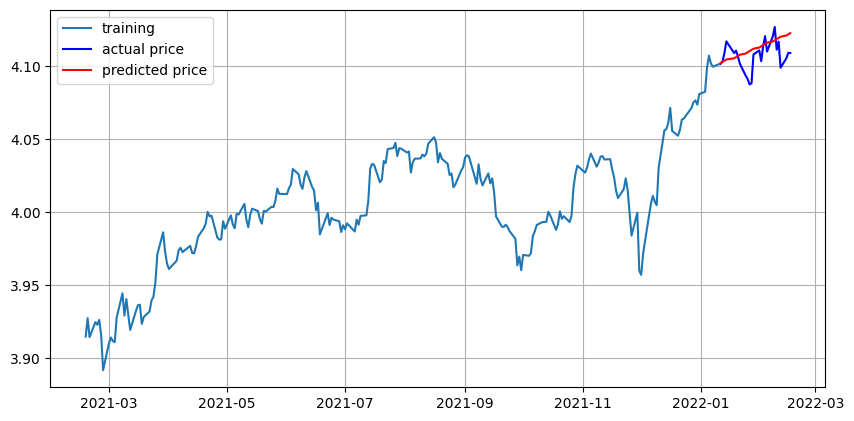

In [57]:
# Forecast : 결과가 fc에 담깁니다. 

fc_3 = fitted_m_3.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_3 = np.array(fc_3)

# Make as pandas series
fc_series_3 = pd.Series(fc_3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_3, c='r',label='predicted price')
plt.legend()
plt.show()

In [58]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.46250049445992986
MAE:  0.5304224288602181
RMSE:  0.6800738889708454
MAPE: 0.88%


## ▶ 최종 MAPE : 0.88% (p = 0, d = 2, q = 1)

---

# [[Pepsi]](https://finance.yahoo.com/quote/PEP?p=PEP&.tsrc=fin-srch)

## 1. 시계열 데이터 준비

In [59]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/PEP.csv'
pepsi = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
pepsi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,134.059998,135.070007,133.860001,134.460007,130.643051,3353000
2021-02-18,134.070007,135.699997,133.910004,135.369995,131.527191,3935200
2021-02-19,135.009995,135.119995,132.289993,132.509995,128.748383,5414900
2021-02-22,132.039993,132.600006,130.759995,131.990005,128.243164,5792900
2021-02-23,132.649994,134.339996,131.300003,132.779999,129.010727,6264300


In [60]:
ts_ps = pepsi['Close']
ts_ps.head()

Date
2021-02-17    134.460007
2021-02-18    135.369995
2021-02-19    132.509995
2021-02-22    131.990005
2021-02-23    132.779999
Name: Close, dtype: float64

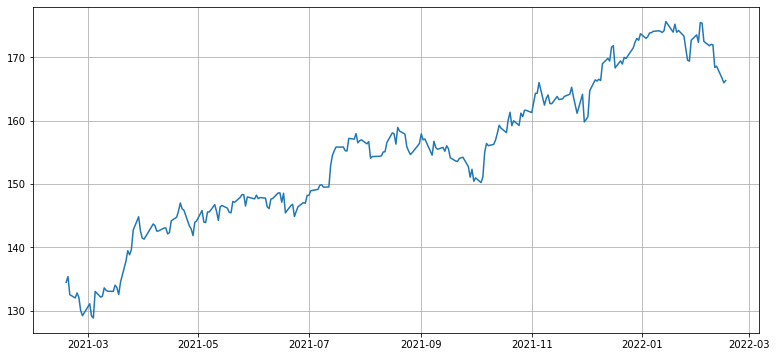

In [61]:
rcParams['figure.figsize'] = 13, 6 

plt.grid(True)
plt.plot(ts_ps)

## 2. 각종 전처리 수행

In [62]:
# 결측치 처리
ts_ps = ts_ps.interpolate(method='time')
ts_ps[ts_ps.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [63]:
# 로그 변환
ts_ps_log = np.log(ts_ps)

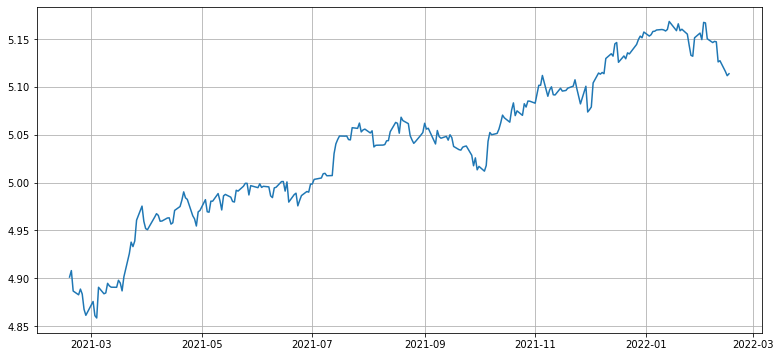

In [64]:
plt.grid(True)
plt.plot(ts_ps_log)

## 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

In [65]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
print('슝=3')

슝=3


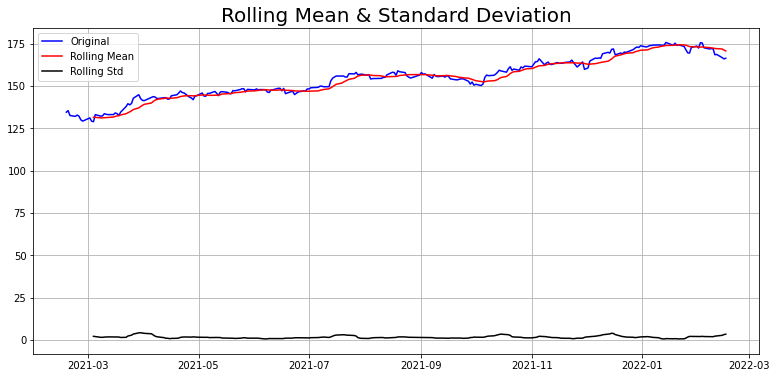

In [66]:
plt.grid(True)
plot_rolling_statistics(ts_ps, window=12)    # time step은 12으로 함.

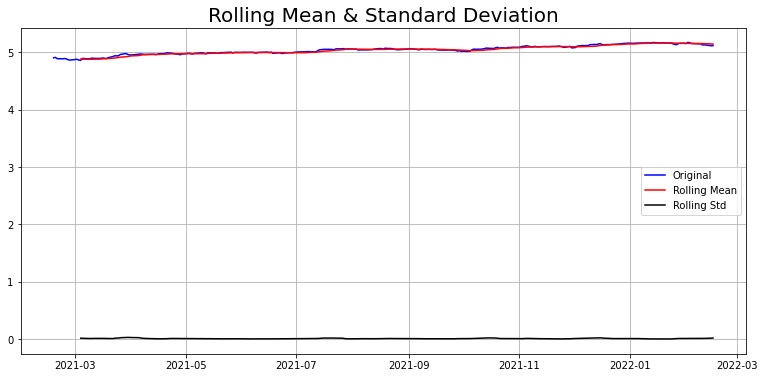

In [67]:
plt.grid(True)
plot_rolling_statistics(ts_ps_log, window=12)

### 3.2 정량적 Augmented Dicky-Fuller Test
* 원 데이터, 로그 변환 데이터 모두 `p-value`값이 0.05 이상이기에 귀무가설을 기각할 수 없다.
* 아직은 이 시계열 데이터가 안정적이지 않다고 볼 수 있다

In [68]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [69]:
augmented_dickey_fuller_test(ts_ps)

Results of Dickey-Fuller Test:
Test Statistic                  -1.413998
p-value                          0.575547
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [70]:
augmented_dickey_fuller_test(ts_ps_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.479279
p-value                          0.543736
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


### 3.3 시계열 분해 

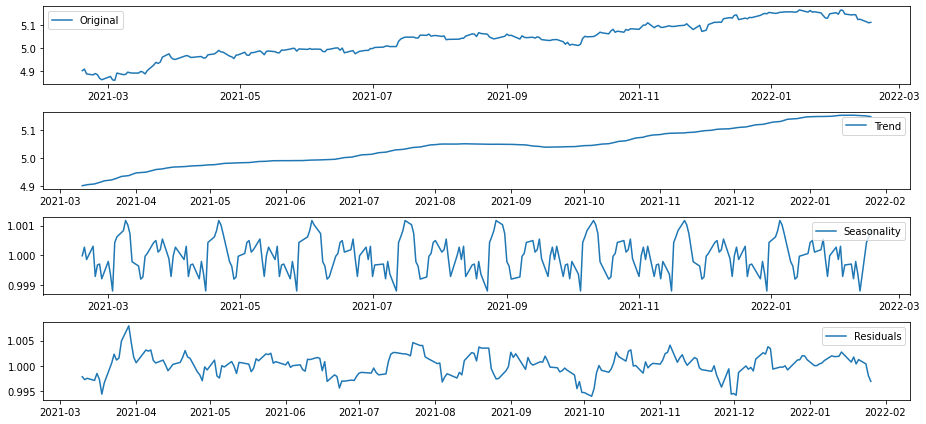

In [71]:
decomposition = seasonal_decompose(ts_ps_log, model='multiplicative', period = 30) 

trend_ps = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal_ps = decomposition.seasonal     # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_ps = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_ps_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_ps, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_ps,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_ps, label='Residuals')   # original 시계열에서 trend와 seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인
* `Decomposing`을 하기 전에 비해 `p-value`값이 작아졌다.
* 이제 예측 가능한 수준의 안정적인 시계열이 얻어졌다.

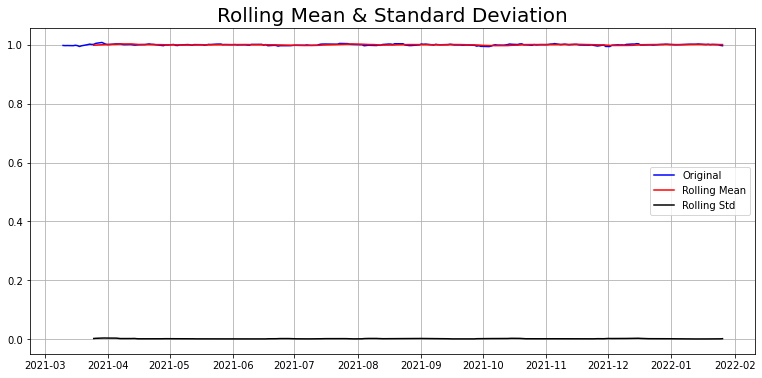

In [72]:
plt.grid(True)
plot_rolling_statistics(residual_ps)

In [73]:
residual_ps.dropna(inplace=True)
augmented_dickey_fuller_test(residual_ps)

Results of Dickey-Fuller Test:
Test Statistic                  -5.479704
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

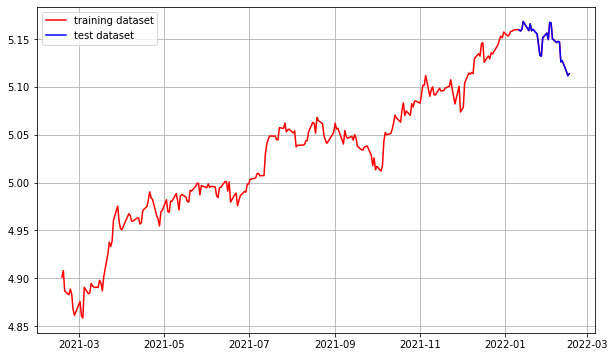

In [74]:
train_data, test_data = ts_ps_log[:int(len(ts_ps_log)*0.9)], ts_ps_log[int(len(ts_ps_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(ts_ps_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

## 5. 적정 ARIMA 파라미터 찾기

### 5.1 ACF, PACF 그려보기 (→ p,q 결정)
* `PACF` 그래프를 보면 `p = 1`이 적합하다.
* `ACF`는 점진적으로 감소하고 있기에 `q = 0`으로 설정하고자 한다.

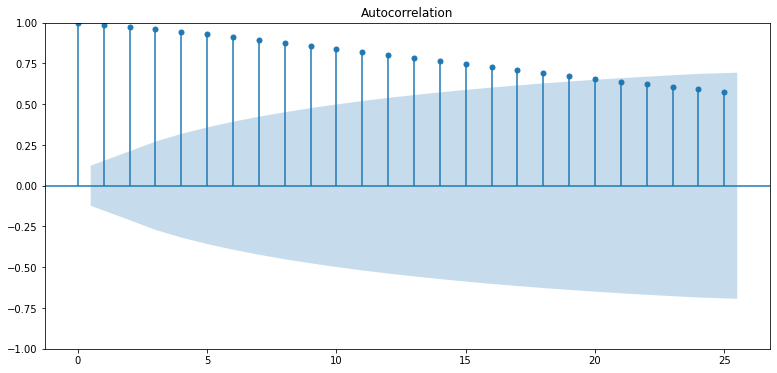

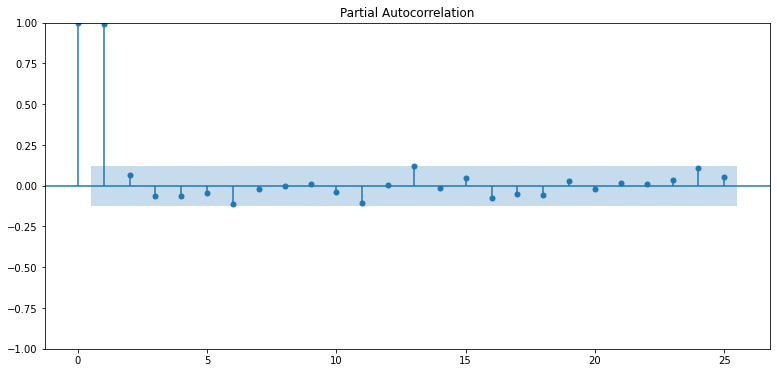

In [75]:
plot_acf(ts_ps_log)  
plot_pacf(ts_ps_log) 
plt.show()

### 5.2 차분 안정성 확인(→ d 결정)
* 1차 차분을 했을 때는, 다른 데이터(삼성전자, cocacola)와 동일하게 그래프가 출력되었다.
* 2차 차분을 했을 때는, `PACF`가 살짝 점차적으로 감소하고 있는 모습이다.

Results of Dickey-Fuller Test:
Test Statistic                -1.712070e+01
p-value                        7.259868e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


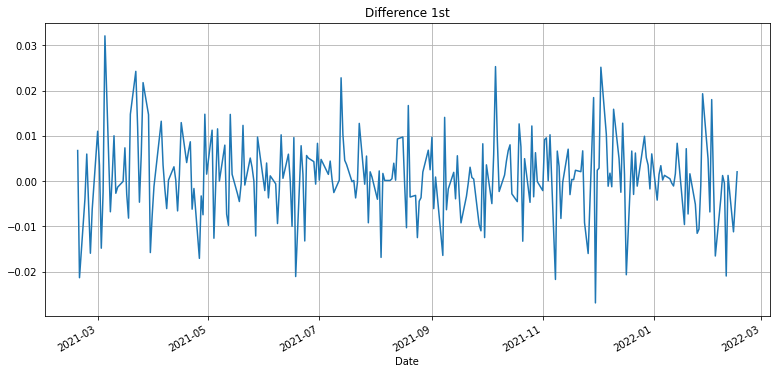

In [76]:
# 1차 차분 구하기
diff_ps_1 = ts_ps_log.diff(periods=1).iloc[1:]
diff_ps_1.plot(title='Difference 1st')
plt.grid(True)

augmented_dickey_fuller_test(diff_ps_1)

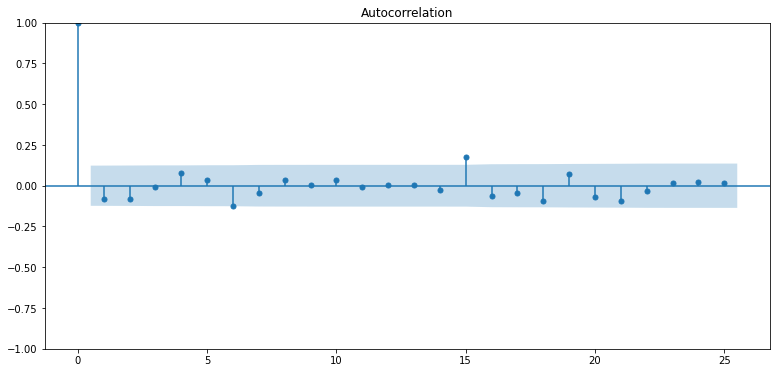

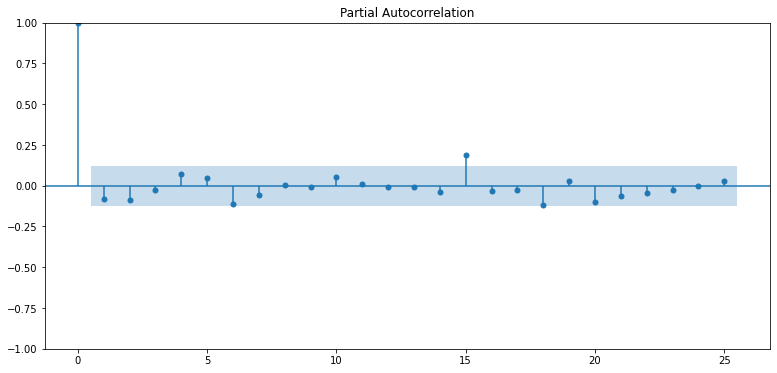

In [77]:
plot_acf(diff_ps_1)   
plot_pacf(diff_ps_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.501581e+00
p-value                        1.234191e-13
#Lags Used                     1.300000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


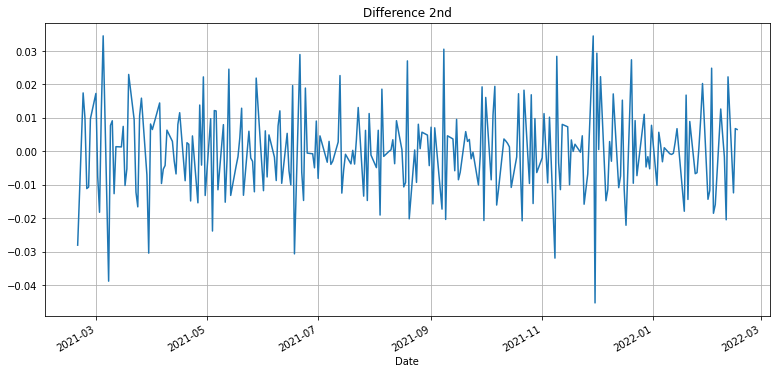

In [78]:
# 2차 차분 구하기
diff_ps_2 = diff_ps_1.diff(periods=1).iloc[1:]
diff_ps_2.plot(title='Difference 2nd')
plt.grid(True)

augmented_dickey_fuller_test(diff_ps_2)

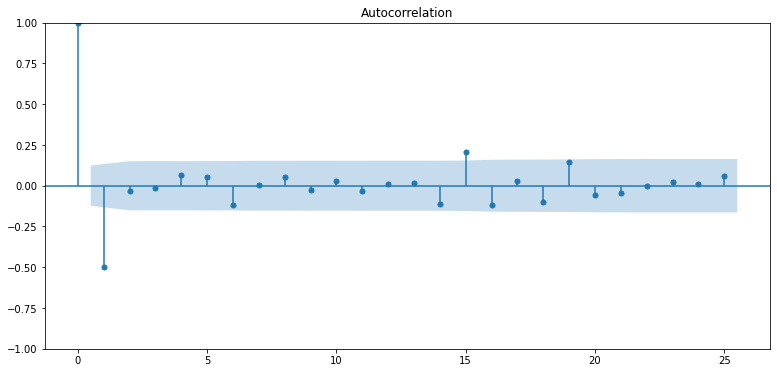

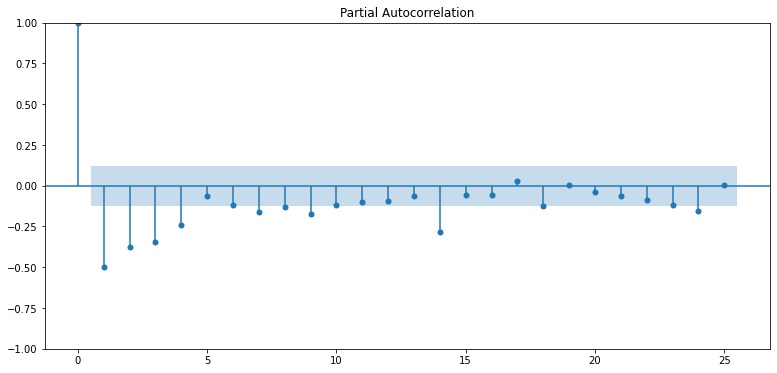

In [79]:
plot_acf(diff_ps_2)   
plot_pacf(diff_ps_2)
plt.show()

## 6. ARIMA 모델 훈련과 테스트

## [p = 1, d = 0, q = 0]
* 1차 차분을 하지 않았으며, 실제 그래프와 유사하게 하강하는 그래프가 예측되었다.
* `MAPE`도 `1.02%`로 낮게 나와 나름 예측이 잘 되었다고 판단된다.

In [80]:
model_1 = ARIMA(train_data, order=(1, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 752.178
Date:                Thu, 17 Feb 2022   AIC                          -1498.355
Time:                        09:12:49   BIC                          -1488.067
Sample:                             0   HQIC                         -1494.204
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0241      0.058     86.853      0.000       4.911       5.137
ar.L1          0.9937      0.007    134.530      0.000       0.979       1.008
sigma2      7.828e-05    6.2e-06     12.632      0.0

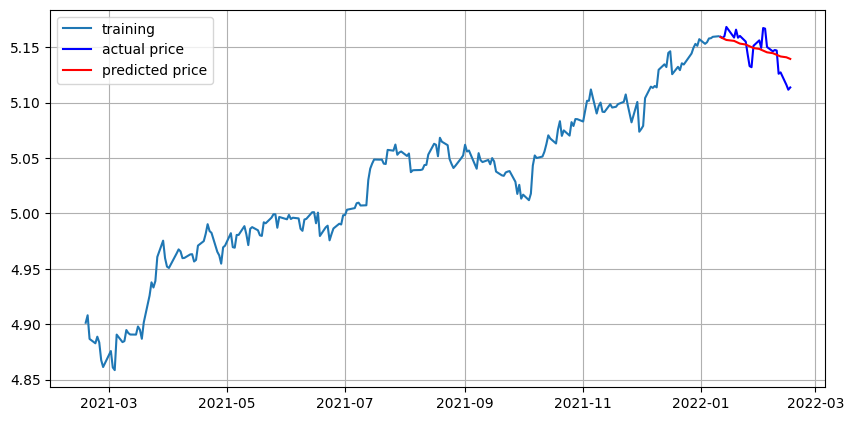

In [81]:
# Forecast : 결과가 fc에 담깁니다. 

fc_1 = fitted_m_1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)

# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [82]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5.140519889289627
MAE:  1.7334163280950605
RMSE:  2.2672714635194495
MAPE: 1.02%


## [p = 0, d = 1, q = 0]
* 1차 차분을 하였는데 예측 그래프가 일직선으로 나왔다.
* `MAPE`는 `1.51%`가 나와 1차 차분을 하지 않았을 때보다 높게 나왔다.

In [83]:
model_2 = ARIMA(train_data, order=(0, 1, 0)) 
fitted_m_2 = model_2.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 751.478
Date:                Thu, 17 Feb 2022   AIC                          -1500.955
Time:                        09:12:50   BIC                          -1497.530
Sample:                             0   HQIC                         -1499.573
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.791e-05   5.82e-06     13.394      0.000    6.65e-05    8.93e-05
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):                13.34
Prob(Q):                              0.15   Pr

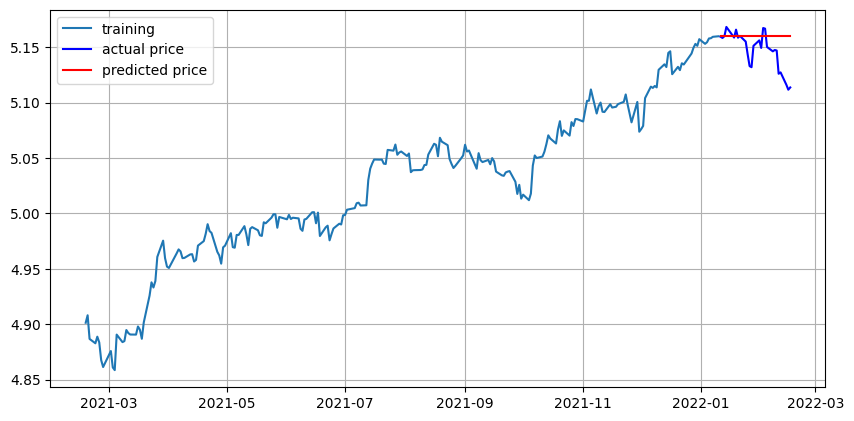

In [84]:
# Forecast : 결과가 fc에 담깁니다. 

fc_2 = fitted_m_2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)

# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

In [85]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12.841309782328949
MAE:  2.550383307692307
RMSE:  3.583477331075076
MAPE: 1.51%


## [p = 0, d = 2, q = 1]
* 2차 차분을 했더니 예측 그래프가 실제 그래프와 상반되게 상승하는 그래프로 그려졌다.
* 그래프에서 확인한 바와 동일하게 `MAPE`는 `2.90%`로 가장 높게 나왔다.
* 가장 예측을 못한 모델이다.

In [86]:
model_3 = ARIMA(train_data, order=(0, 2, 1)) 
fitted_m_3 = model_3.fit() 

print(fitted_m_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 746.854
Date:                Thu, 17 Feb 2022   AIC                          -1489.708
Time:                        09:12:50   BIC                          -1482.867
Sample:                             0   HQIC                         -1486.947
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      1.658     -0.603      0.546      -4.249       2.249
sigma2      7.697e-05      0.000      0.603      0.547      -0.000       0.000
Ljung-Box (L1) (Q):                   1.77   Jarque-

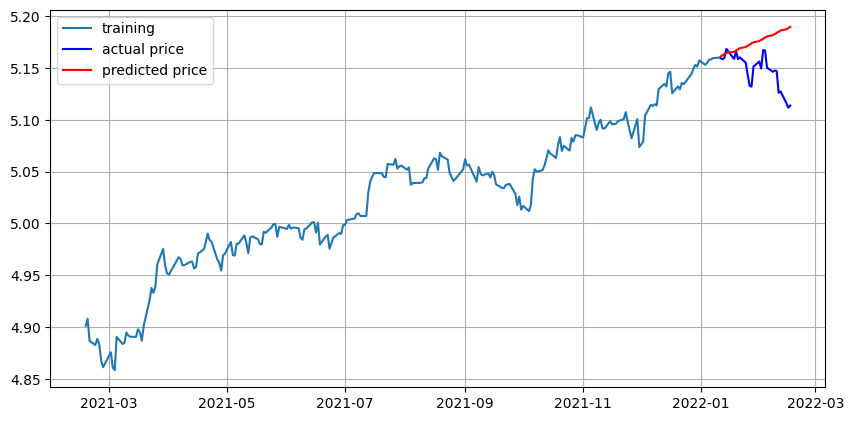

In [87]:
# Forecast : 결과가 fc에 담깁니다. 

fc_3 = fitted_m_3.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_3 = np.array(fc_3)

# Make as pandas series
fc_series_3 = pd.Series(fc_3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_3, c='r',label='predicted price')
plt.legend()
plt.show()

In [88]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc_3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40.40405864559534
MAE:  4.919835239676271
RMSE:  6.3564186965299365
MAPE: 2.90%


## ▶ 최종 MAPE : 1.02% (p = 1, d = 0, q = 0)

---

# [[DISNEY]](https://finance.yahoo.com/quote/DIS?p=DIS&.tsrc=fin-srch)

## 1. 시계열 데이터 준비

In [89]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DIS.csv'
disney = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
disney.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,185.360001,187.630005,182.160004,186.440002,186.440002,11391800
2021-02-18,184.789993,186.399994,182.839996,183.000000,183.000000,12380900
2021-02-19,184.270004,184.779999,182.789993,183.649994,183.649994,8834500
2021-02-22,181.740005,194.020004,181.529999,191.759995,191.759995,18799600
2021-02-23,193.589996,198.940002,188.660004,197.089996,197.089996,23191400


In [90]:
ts_dn = disney['Close']
ts_dn.head()

Date
2021-02-17    186.440002
2021-02-18    183.000000
2021-02-19    183.649994
2021-02-22    191.759995
2021-02-23    197.089996
Name: Close, dtype: float64

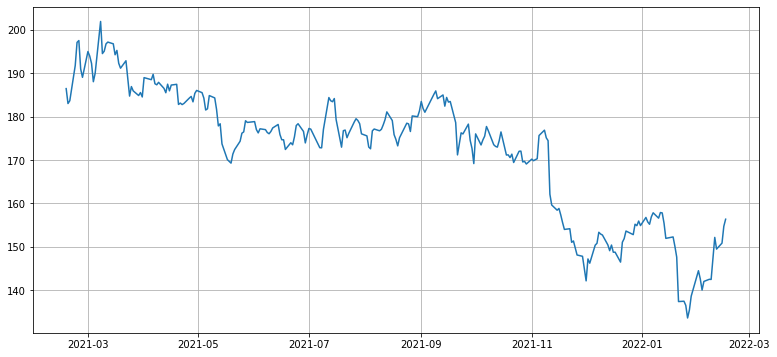

In [91]:
rcParams['figure.figsize'] = 13, 6 

plt.grid(True)
plt.plot(ts_dn)

## 2. 각종 전처리 수행

In [92]:
# 결측치 처리
ts_dn = ts_dn.interpolate(method='time')
ts_dn[ts_dn.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [93]:
# 로그 변환
ts_dn_log = np.log(ts_dn)

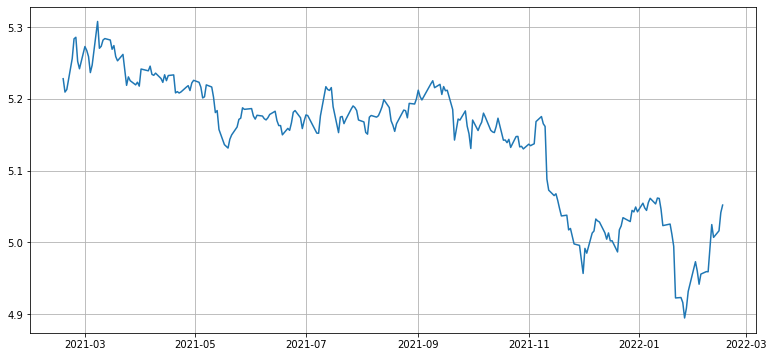

In [94]:
plt.grid(True)
plt.plot(ts_dn_log)

## 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

In [95]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
print('슝=3')

슝=3


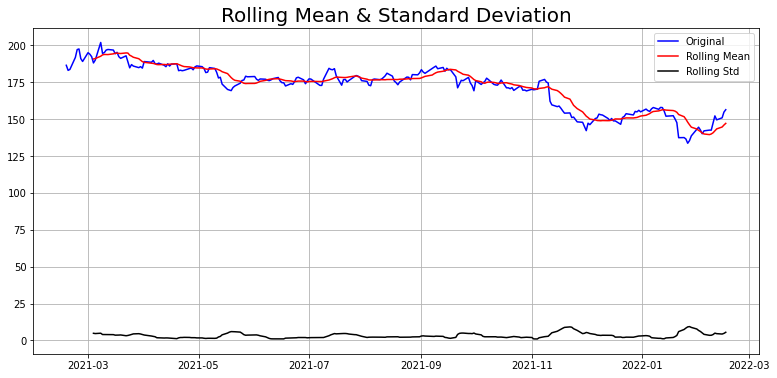

In [96]:
plt.grid(True)
plot_rolling_statistics(ts_dn, window=12)    # time step은 12으로 함.

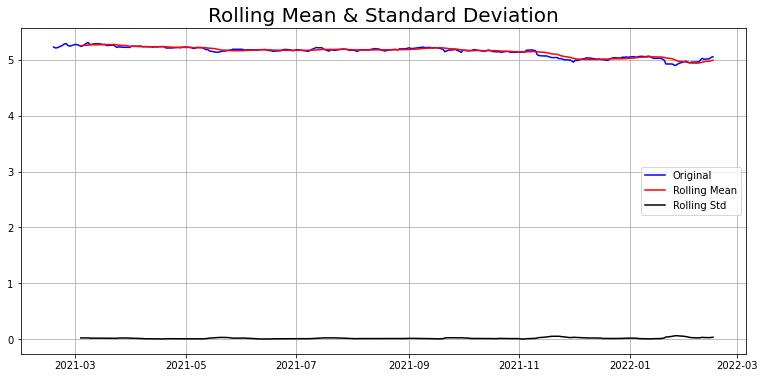

In [97]:
plt.grid(True)
plot_rolling_statistics(ts_dn_log, window=12)

### 3.2 정량적 Augmented Dicky-Fuller Test
* 원 데이터, 로그 변환 데이터 모두 `p-value`값이 0.05 이상이기에 귀무가설을 기각할 수 없다.
* 아직은 이 시계열 데이터가 안정적이지 않다고 볼 수 있다

In [98]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [99]:
augmented_dickey_fuller_test(ts_dn)

Results of Dickey-Fuller Test:
Test Statistic                  -1.403280
p-value                          0.580702
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


In [100]:
augmented_dickey_fuller_test(ts_dn_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.408384
p-value                          0.578250
#Lags Used                       1.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


### 3.3 시계열 분해

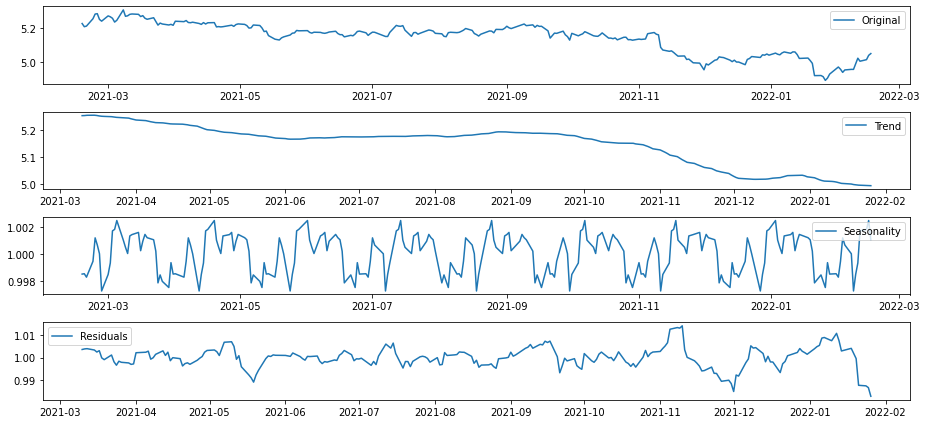

In [101]:
decomposition = seasonal_decompose(ts_dn_log, model='multiplicative', period = 30) 

trend_dn = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal_dn = decomposition.seasonal     # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_dn = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_dn_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_dn, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_dn,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_dn, label='Residuals')   # original 시계열에서 trend와 seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인
* `Decomposing`을 하기 전에 비해 `p-value`값이 작아졌다.
* 이제 예측 가능한 수준의 안정적인 시계열이 얻어졌다.

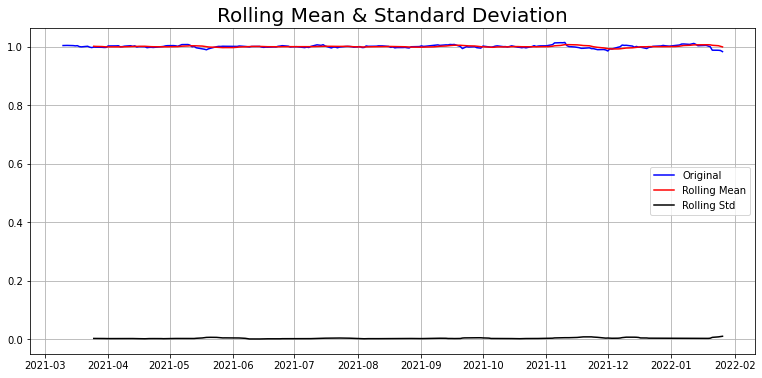

In [102]:
plt.grid(True)
plot_rolling_statistics(residual_dn)

In [103]:
residual_dn.dropna(inplace=True)
augmented_dickey_fuller_test(residual_dn)

Results of Dickey-Fuller Test:
Test Statistic                  -5.217698
p-value                          0.000008
#Lags Used                       4.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

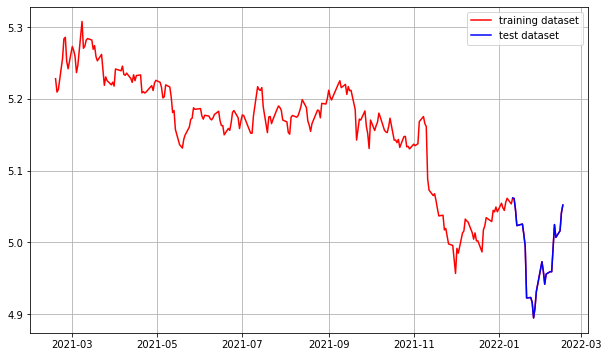

In [104]:
train_data, test_data = ts_dn_log[:int(len(ts_dn_log)*0.9)], ts_dn_log[int(len(ts_dn_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(ts_dn_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

## 5. 적정 ARIMA 파라미터 찾기

### 5.1 ACF, PACF 그려보기 (→ p,q 결정)
* `PACF` 그래프를 보면 `p = 1`이 적합하다.
* `ACF`는 점진적으로 감소하고 있기에 `q = 0`으로 설정하고자 한다.

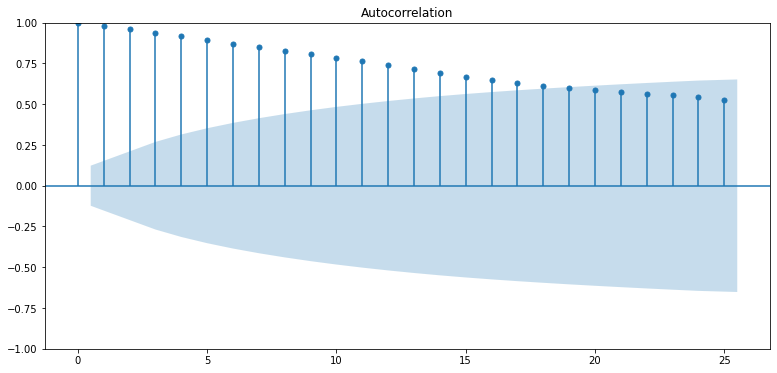

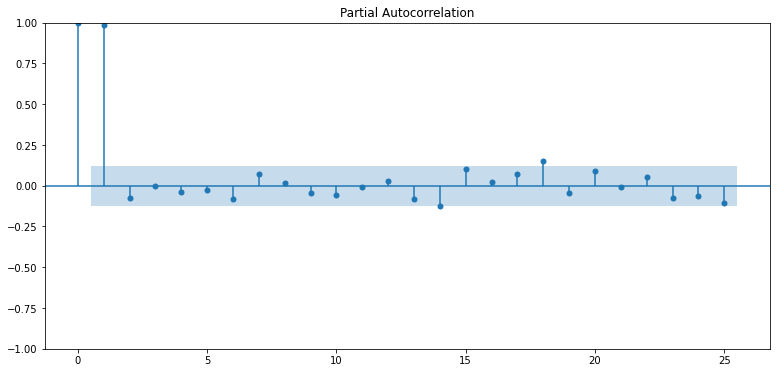

In [105]:
plot_acf(ts_dn_log)  
plot_pacf(ts_dn_log) 
plt.show()

### 5.2 차분 안정성 확인(→ d 결정)
* 1차 차분과 2차 차분은 다른 데이터와 동일한 형태로 나와 동일하게 판단하고자 한다.

Results of Dickey-Fuller Test:
Test Statistic                -1.480968e+01
p-value                        2.039490e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


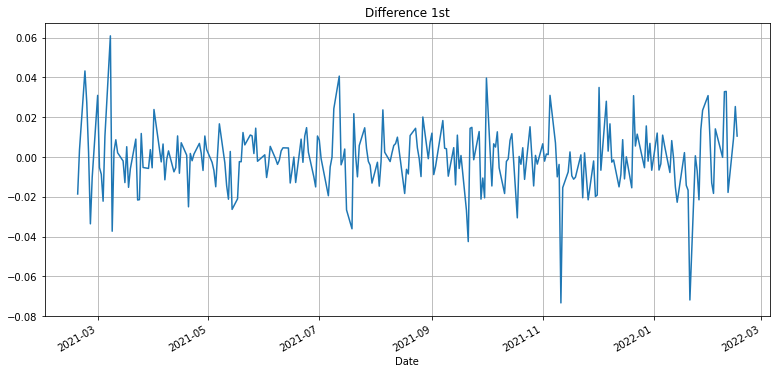

In [106]:
# 1차 차분 구하기
diff_dn_1 = ts_dn_log.diff(periods=1).iloc[1:]
diff_dn_1.plot(title='Difference 1st')
plt.grid(True)

augmented_dickey_fuller_test(diff_dn_1)

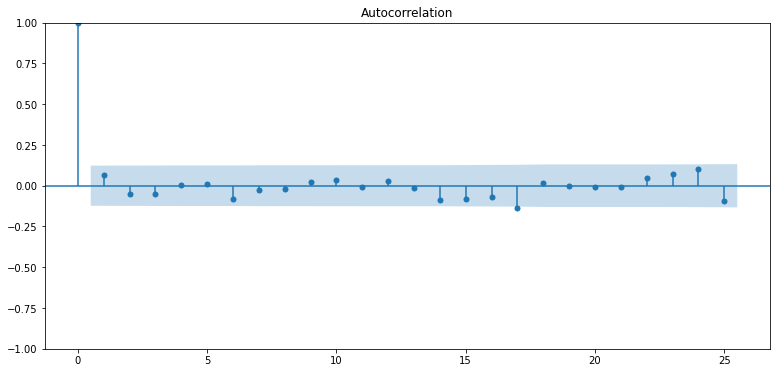

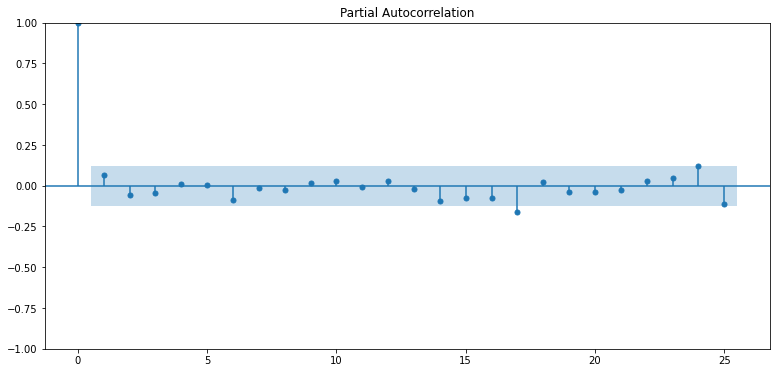

In [107]:
plot_acf(diff_dn_1)   
plot_pacf(diff_dn_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.450467e+00
p-value                        1.667755e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


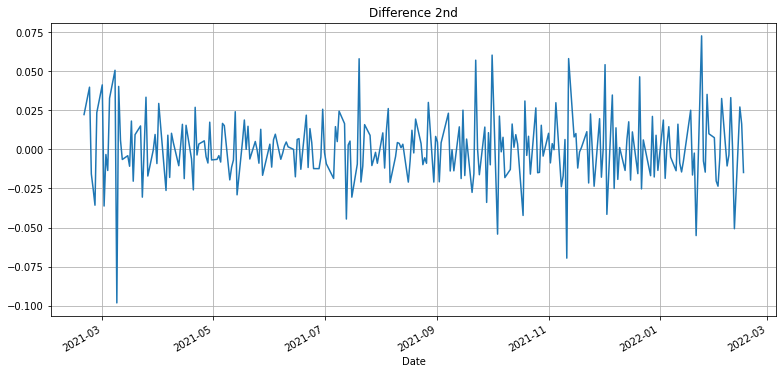

In [108]:
# 2차 차분 구하기
diff_dn_2 = diff_dn_1.diff(periods=1).iloc[1:]
diff_dn_2.plot(title='Difference 2nd')
plt.grid(True)

augmented_dickey_fuller_test(diff_dn_2)

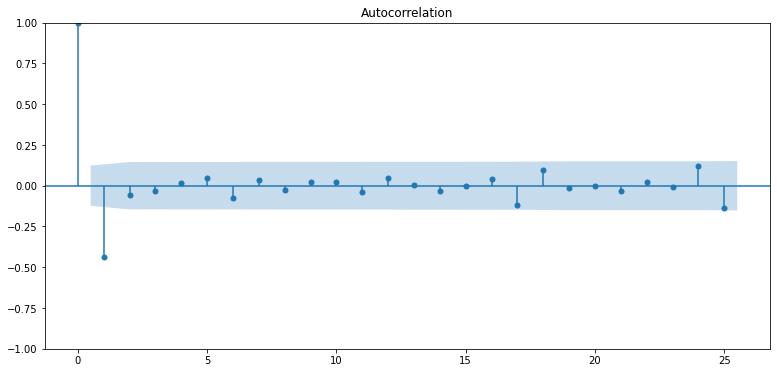

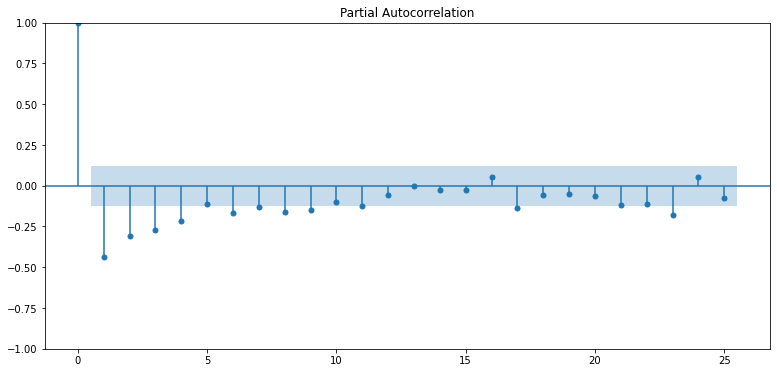

In [109]:
plot_acf(diff_dn_2)   
plot_pacf(diff_dn_2)
plt.show()

## 6. ARIMA 모델 훈련과 테스트

## [p = 1, d = 0, q = 0]
* 실제 그래프가 급하강하다 급상승을 하여 제대로 예측을 하지 못한 것 같다.
* `MAPE`는 `9.96%`이 나왔다.

In [110]:
# ARIMA 모델 빌드와 훈련

model_1 = ARIMA(train_data, order=(1, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 634.438
Date:                Thu, 17 Feb 2022   AIC                          -1262.876
Time:                        09:12:54   BIC                          -1252.588
Sample:                             0   HQIC                         -1258.725
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1632      0.049    106.441      0.000       5.068       5.258
ar.L1          0.9824      0.012     79.825      0.000       0.958       1.006
sigma2         0.0002   1.24e-05     17.845      0.0

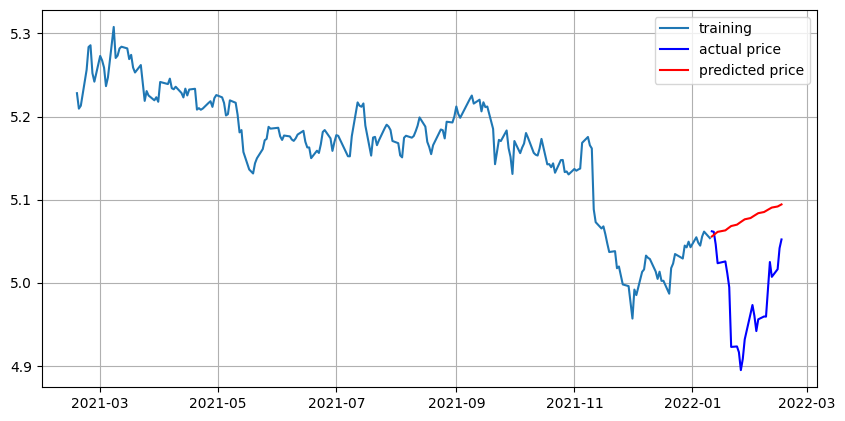

In [111]:
# 모델 테스트 및 플로팅

fc_1 = fitted_m_1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)

# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [112]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  256.43375669085873
MAE:  14.161888397202192
RMSE:  16.0135491597228
MAPE: 9.96%


## [p = 0, d = 1, q = 0]
* 예측 그래프의 형태가 일직선으로 그려졌다.
* 그래도 `MAPE`는 `7.54%`로 1차 차분을 하지 않은 모델보다 예측을 잘했다.

In [113]:
# ARIMA 모델 빌드와 훈련

model_2 = ARIMA(train_data, order=(0, 1, 0)) 
fitted_m_2 = model_2.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 632.308
Date:                Thu, 17 Feb 2022   AIC                          -1262.615
Time:                        09:12:54   BIC                          -1259.191
Sample:                             0   HQIC                         -1261.233
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   1.26e-05     17.730      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               118.53
Prob(Q):                              0.83   Pr

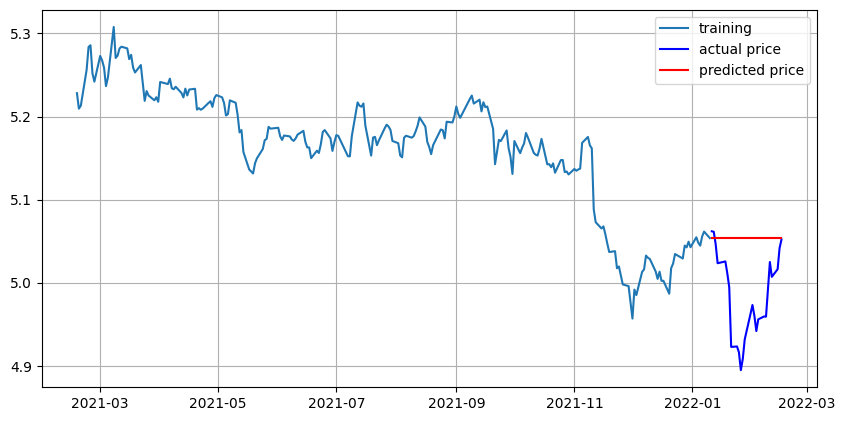

In [114]:
# 모델 테스트 및 플로팅

fc_2 = fitted_m_2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)

# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

In [115]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  162.1333409254224
MAE:  10.638850192307665
RMSE:  12.733159110190307
MAPE: 7.54%


## [p = 0, d = 2, q = 1]
* 2차 차분을 한 결과, 하강 그래프로 예측이 되었다.
* `MAPE`는 `6.64%`로 나와 가장 예측이 잘된 모델이다.

In [116]:
# ARIMA 모델 빌드와 훈련

model_3 = ARIMA(train_data, order=(0, 2, 1)) 
fitted_m_3 = model_3.fit() 

print(fitted_m_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 626.611
Date:                Thu, 17 Feb 2022   AIC                          -1249.221
Time:                        09:12:55   BIC                          -1242.380
Sample:                             0   HQIC                         -1246.460
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      2.997     -0.334      0.739      -6.873       4.873
sigma2         0.0002      0.001      0.334      0.739      -0.001       0.002
Ljung-Box (L1) (Q):                   0.13   Jarque-

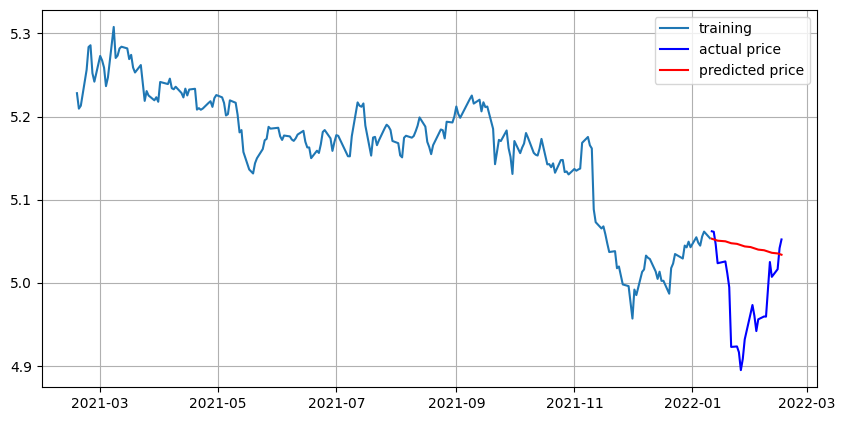

In [117]:
# 모델 테스트 및 플로팅

fc_3 = fitted_m_3.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_3 = np.array(fc_3)

# Make as pandas series
fc_series_3 = pd.Series(fc_3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_3, c='r',label='predicted price')
plt.legend()
plt.show()

In [118]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  131.03309677319007
MAE:  9.356792288536534
RMSE:  11.446968890199276
MAPE: 6.64%


## ▶ 최종 MAPE : 6.64% (p = 0, d = 2, q = 1)

---

# [[Netflix]](https://finance.yahoo.com/quote/NFLX?p=NFLX&.tsrc=fin-srch)

## 1. 시계열 데이터 준비

In [119]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
netflix = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
netflix.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-17,550.98999,555.250000,543.030029,551.340027,551.340027,2069600
2021-02-18,549.00000,550.000000,538.229980,548.219971,548.219971,2456200
2021-02-19,548.00000,548.989990,538.809998,540.219971,540.219971,2841500
2021-02-22,534.98999,541.789978,530.789978,533.780029,533.780029,3078600
2021-02-23,525.00000,548.539978,518.280029,546.150024,546.150024,4136500


In [120]:
ts_nf = netflix['Close']
ts_nf.head()

Date
2021-02-17    551.340027
2021-02-18    548.219971
2021-02-19    540.219971
2021-02-22    533.780029
2021-02-23    546.150024
Name: Close, dtype: float64

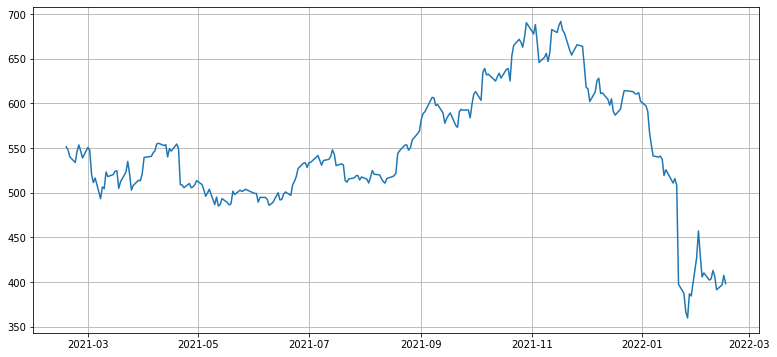

In [121]:
rcParams['figure.figsize'] = 13, 6 

plt.grid(True)
plt.plot(ts_nf)

## 2. 각종 전처리 수행

In [122]:
# 결측치 처리
ts_nf = ts_nf.interpolate(method='time')
ts_nf[ts_nf.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [123]:
# 로그 변환
ts_nf_log = np.log(ts_nf)

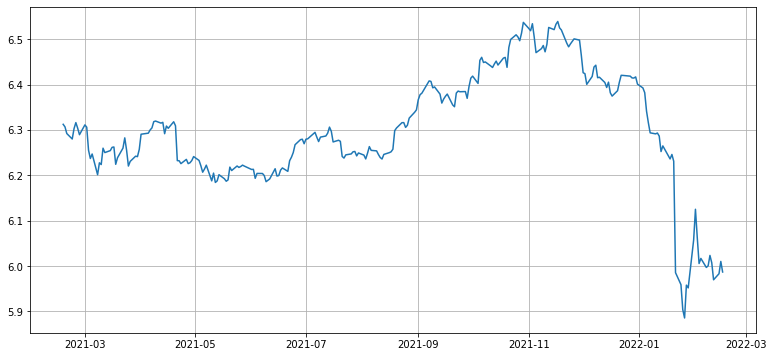

In [124]:
plt.grid(True)
plt.plot(ts_nf_log)

## 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

In [125]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize = 20)
    plt.show(block=False)
    
print('슝=3')

슝=3


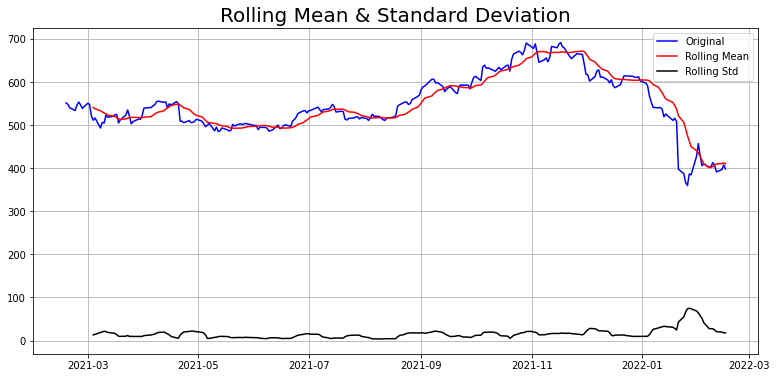

In [126]:
plt.grid(True)
plot_rolling_statistics(ts_nf, window=12)    # time step은 12으로 함.

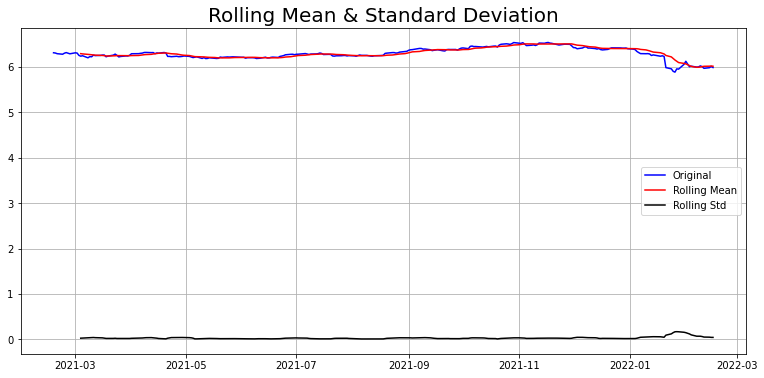

In [127]:
plt.grid(True)
plot_rolling_statistics(ts_nf_log, window=12)

### 3.2 정량적 Augmented Dicky-Fuller Test
* 원 데이터, 로그 변환 데이터 모두 `p-value`값이 0.05 이상이기에 귀무가설을 기각할 수 없다.
* 아직은 이 시계열 데이터가 안정적이지 않다고 볼 수 있다

In [128]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [129]:
augmented_dickey_fuller_test(ts_nf)

Results of Dickey-Fuller Test:
Test Statistic                  -0.684206
p-value                          0.850798
#Lags Used                       4.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [130]:
augmented_dickey_fuller_test(ts_nf_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.614173
p-value                          0.867747
#Lags Used                       4.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 3.3 시계열 분해

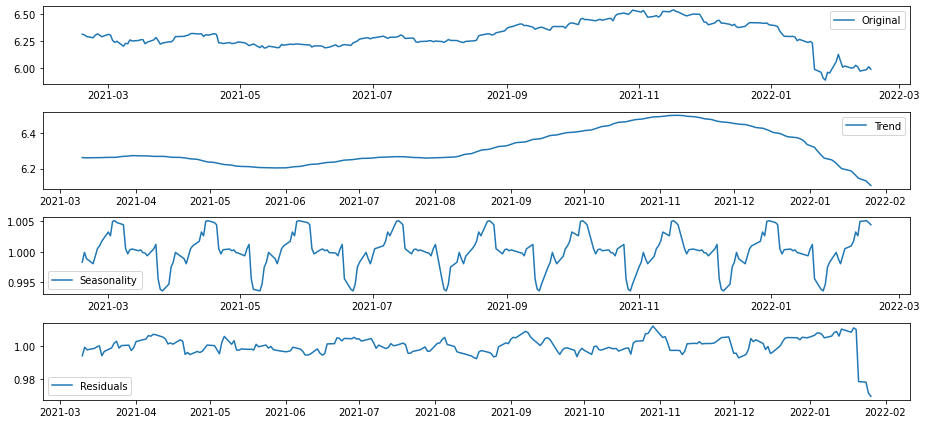

In [131]:
decomposition = seasonal_decompose(ts_nf_log, model='multiplicative', period = 30) 

trend_nf = decomposition.trend           # 추세(시간 추이에 따라 나타나는 평균값 변화)
seasonal_nf = decomposition.seasonal     # 계절성(패턴이 파악되지 않은 주기적 변화)
residual_nf = decomposition.resid        # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_nf_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_nf, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_nf,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_nf, label='Residuals')   # original 시계열에서 trend와 seasonality를 제거한 나머지
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안정성 확인
* `p-value`값이 확실히 낮아져 예측 가능한 수준의 안정적인 시계열이 얻어졌다.

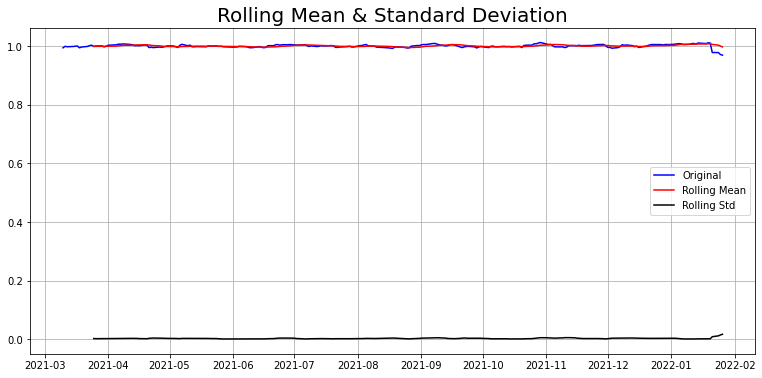

In [132]:
plt.grid(True)
plot_rolling_statistics(residual_nf)

In [133]:
residual_nf.dropna(inplace=True)
augmented_dickey_fuller_test(residual_nf)

Results of Dickey-Fuller Test:
Test Statistic                  -4.411351
p-value                          0.000283
#Lags Used                       9.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

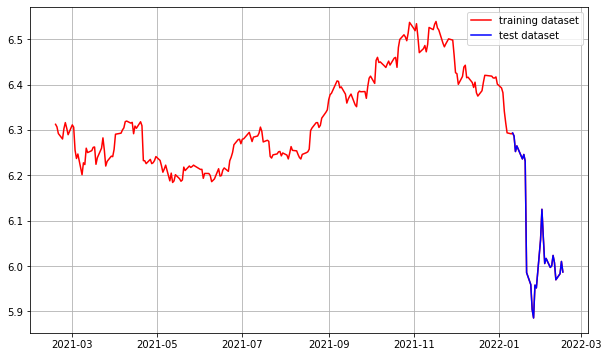

In [134]:
train_data, test_data = ts_nf_log[:int(len(ts_nf_log)*0.9)], ts_nf_log[int(len(ts_nf_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(ts_nf_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')

plt.legend()

## 5. 적정 ARIMA 파라미터 찾기

### 5.1 ACF, PACF 그려보기 (→ p,q 결정)
* `PACF` 그래프를 보면 `p = 1`이 적합하다.
* `ACF`는 점진적으로 감소하고 있기에 `q = 0`으로 설정하고자 한다.

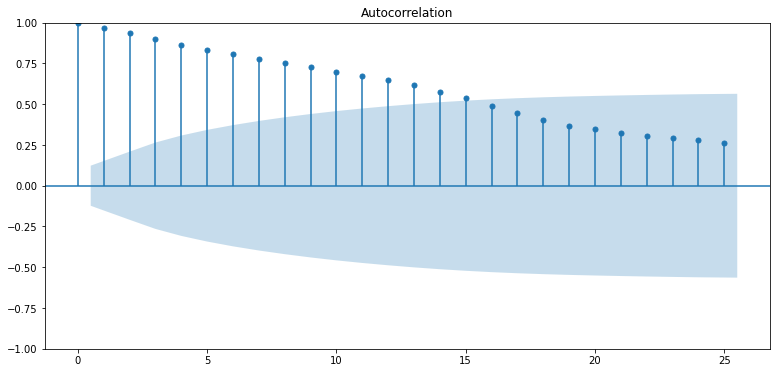

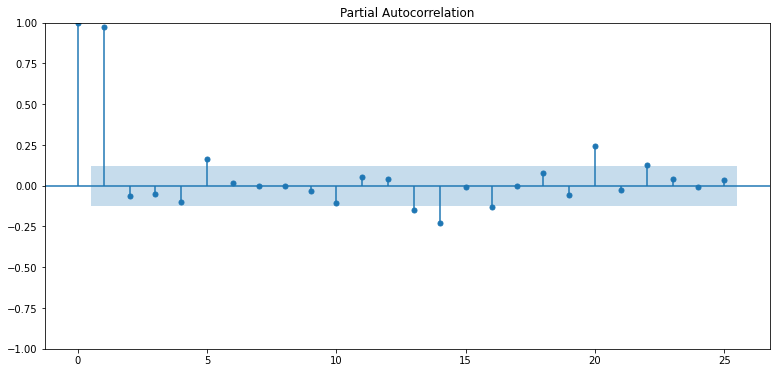

In [135]:
plot_acf(ts_nf_log)  
plot_pacf(ts_nf_log) 
plt.show()

### 5.2 차분 안정성 확인(→ d 결정)
* 1차 차분과 2차 차분은 다른 데이터와 동일한 형태로 나와 동일하게 판단하고자 한다.

Results of Dickey-Fuller Test:
Test Statistic                -8.699931e+00
p-value                        3.833695e-14
#Lags Used                     3.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


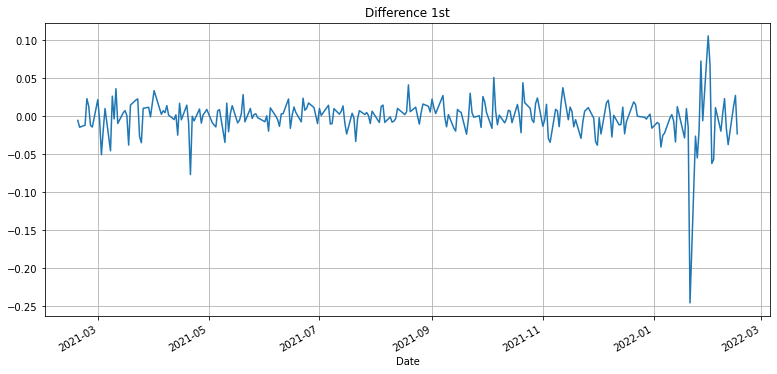

In [136]:
### 5.2 차분 안정성 확인(→ d 결정)
* 1차 차분과 2차 차분은 다른 데이터와 동일한 형태로 나와 동일하게 판단하고자 한다.# 1차 차분 구하기
diff_nf_1 = ts_nf_log.diff(periods=1).iloc[1:]
diff_nf_1.plot(title='Difference 1st')
plt.grid(True)

augmented_dickey_fuller_test(diff_nf_1)

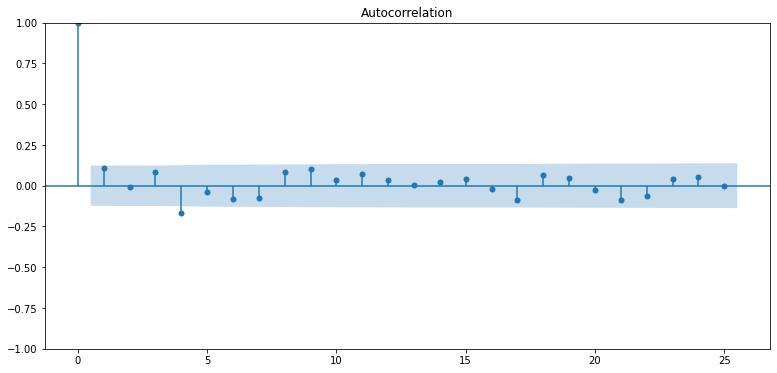

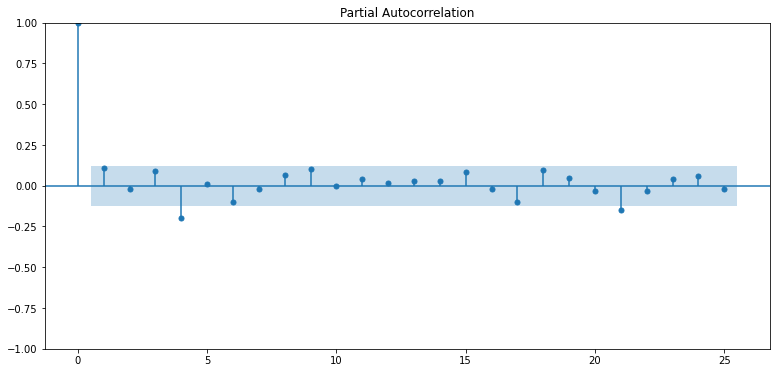

In [137]:
plot_acf(diff_nf_1)   
plot_pacf(diff_nf_1)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.257299e+00
p-value                        4.307662e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


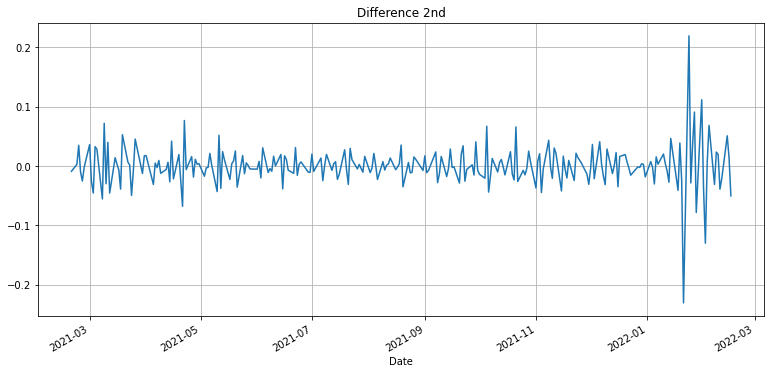

In [138]:
# 2차 차분 구하기
diff_nf_2 = diff_nf_1.diff(periods=1).iloc[1:]
diff_nf_2.plot(title='Difference 2nd')
plt.grid(True)

augmented_dickey_fuller_test(diff_nf_2)

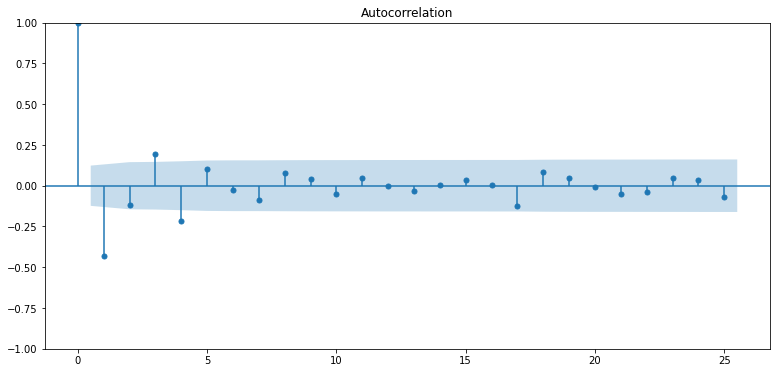

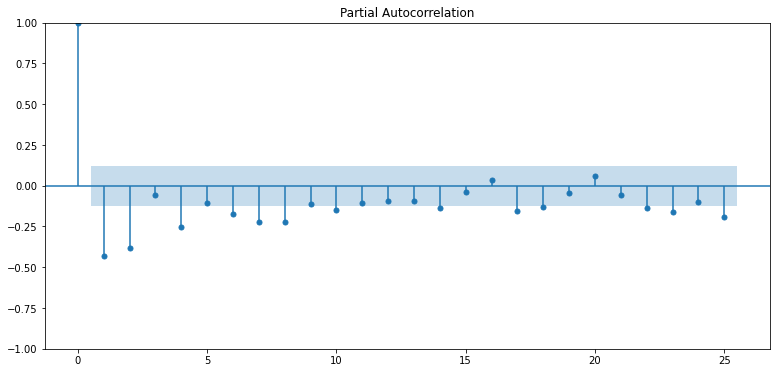

In [139]:
plot_acf(diff_nf_2)   
plot_pacf(diff_nf_2)
plt.show()

## 6. ARIMA 모델 훈련과 테스트

## [p = 1, d = 0, q = 0]
* 실제 그래프는 급하강하고 있는데, 예측 그래프는 일직선에서 살짝 상승하는 것으로 그려졌다.
* `MAPE`는 `26.90%`로 확실히 높은 수치를 보인다.

In [140]:
# ARIMA 모델 빌드와 훈련

model_1 = ARIMA(train_data, order=(1, 0, 0)) 
fitted_m_1 = model_1.fit() 

print(fitted_m_1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 607.704
Date:                Thu, 17 Feb 2022   AIC                          -1209.408
Time:                        09:12:59   BIC                          -1199.120
Sample:                             0   HQIC                         -1205.257
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3159      0.085     74.054      0.000       6.149       6.483
ar.L1          0.9861      0.011     90.560      0.000       0.965       1.007
sigma2         0.0003   1.89e-05     14.735      0.0

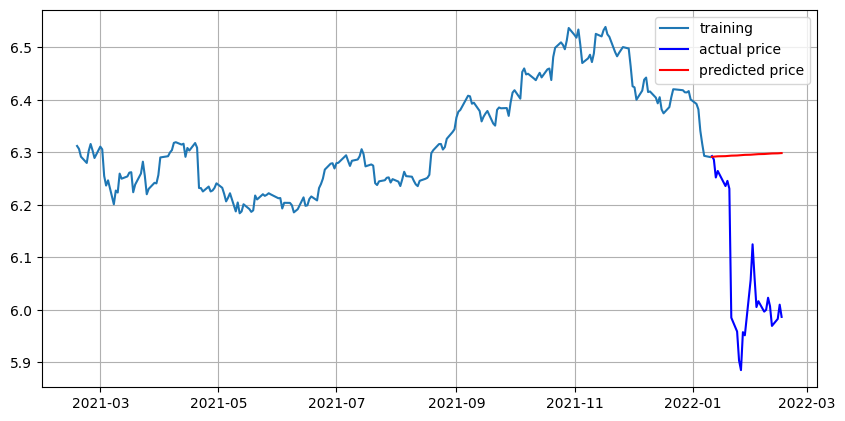

In [141]:
# 모델 테스트 및 플로팅 

fc_1 = fitted_m_1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_1 = np.array(fc_1)

# Make as pandas series
fc_series_1 = pd.Series(fc_1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [142]:
#최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14999.24967461069
MAE:  108.01323980466378
RMSE:  122.47142391027668
MAPE: 26.90%


## [p = 0, d = 1, q = 0]
* 1차 차분을 한 예측 그래프는 일직선을 나타내고 있다.
* 이 모델 역시 `MAPE`가 `26.36%`로 여전히 높다.

In [143]:
# ARIMA 모델 빌드와 훈련

model_2 = ARIMA(train_data, order=(0, 1, 0)) 
fitted_m_2 = model_2.fit() 

print(fitted_m_2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 605.548
Date:                Thu, 17 Feb 2022   AIC                          -1209.096
Time:                        09:12:59   BIC                          -1205.671
Sample:                             0   HQIC                         -1207.714
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   1.85e-05     15.204      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                51.38
Prob(Q):                              0.39   Pr

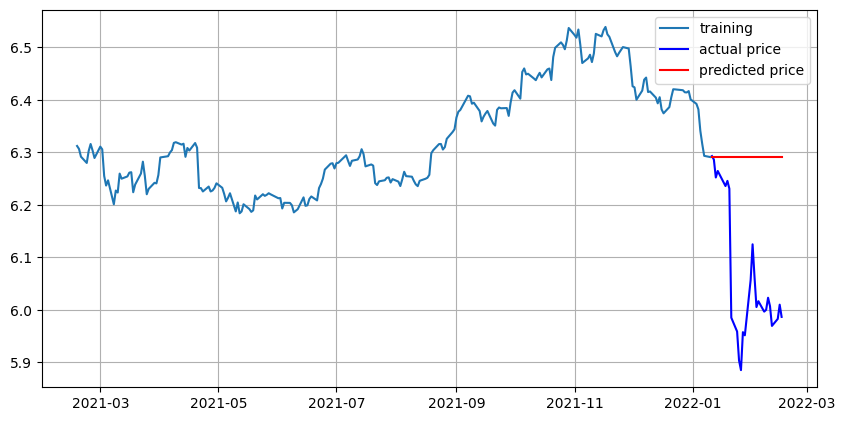

In [144]:
# 모델 테스트 및 플로팅

fc_2 = fitted_m_2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_2 = np.array(fc_2)

# Make as pandas series
fc_series_2 = pd.Series(fc_2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_2, c='r',label='predicted price')
plt.legend()
plt.show()

In [145]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14427.114088858523
MAE:  105.79459365384622
RMSE:  120.11292223927667
MAPE: 26.36%


## [p = 0, d = 2, q = 1]
* 2차 차분한 예측 그래프는 하강하고 있는 것으로 그려졌다.
* 그나마 가장 예측을 잘하였다 판단이 되며 `MAPE`는 `20.93%`로 다른 파라미터를 사용한 모델들 보다는 낮은 값이지만 그래도 여전히 높은 값으로 예측을 잘하는 모델이라고는 말할 수 없다.

In [146]:
# ARIMA 모델 빌드와 훈련

model_3 = ARIMA(train_data, order=(0, 2, 1)) 
fitted_m_3 = model_3.fit() 

print(fitted_m_3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 599.866
Date:                Thu, 17 Feb 2022   AIC                          -1195.732
Time:                        09:12:59   BIC                          -1188.891
Sample:                             0   HQIC                         -1192.971
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9740      0.025    -39.573      0.000      -1.022      -0.926
sigma2         0.0003   1.96e-05     14.623      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.42   Jarque-

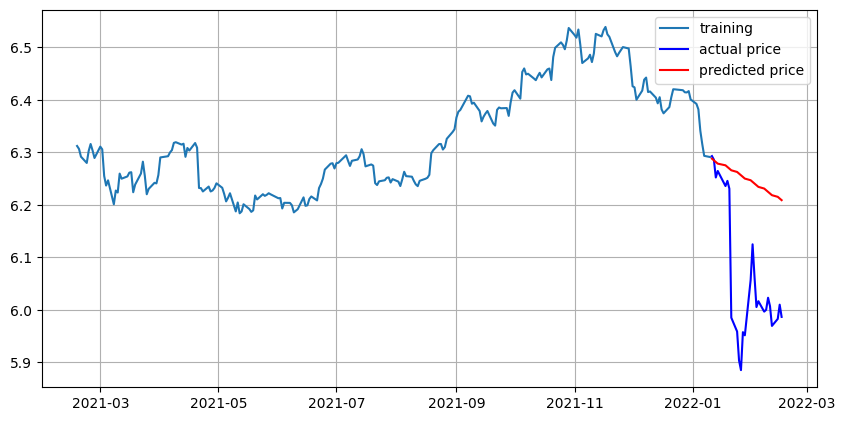

In [147]:
# 모델 테스트 및 플로팅

fc_3 = fitted_m_3.forecast(len(test_data), alpha=0.05)  # 95% conf
fc_3 = np.array(fc_3)

# Make as pandas series
fc_series_3 = pd.Series(fc_3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.grid(True)

plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_3, c='r',label='predicted price')
plt.legend()
plt.show()

In [148]:
# 최종 예측 모델 정확도 측정(MAPE)

mse = mean_squared_error(np.exp(test_data), np.exp(fc_3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc_3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9377.20993976789
MAE:  83.57822768193354
RMSE:  96.83599506262065
MAPE: 20.93%


## ▶ 최종 MAPE : 20.93% (p = 0, d = 2, q = 1)

---
---
---

# 🌞 회고

# 1) 예측 모델 결과

> 삼성전자 : 1.05% (p = 1, d = 0, q = 0)  
> 코카콜라 : 0.88% (p = 0, d = 2, q = 1)  
> 펩시 : 1.02% (p = 1, d = 0, q = 0)  
> 디즈니 : 6.64% (p = 0, d = 2, q = 1)  
> 넷플릭스 : 20.93% (p = 0, d = 2, q = 1)  

* 삼성전자, 코카콜라, 펩시는 `MAPE`가 낮게 나왔으나 디즈니, 넷플릭스는 높게 나왔다.
* trend가 오르락내리락 하는 경우, 그래프가 급격하게 변하는 경우에는 예측이 잘 되지 않는 것 같다.
* 특히 test data 부분의 그래프가 일정치 않아서 더욱 그런 것 같다.
* 차분을 했을 때, 안했을 때의 차이도 분명히 있어서 파라미터를 확인하고 조정해보는 것이 재미있긴 했다.

# 2) 후기
* ARIMA 모델의 파라미터를 설정할 때 근거가 명확하지 않고 이런거지 않을까?라는 생각으로 진행해서 이 부분이 조금 아쉬웠다.
* 프로젝트를 촉박하게 진행하다보니 여러모로 아쉬운 부분이 많았다.
* 이번 프로젝트를 하면서 통계적 지식이 너무 부족하다는 것을 느꼈다. 데이터쪽을 다루려면 통계를 공부해야하는데, 통계를 제대로 공부해야겠다는 생각이 들었다.